# Gaussian Process Regression for Uncertainty Estimation of Performance Evaluations in Configurable Software Systems
# a proof of concept

## Domain
### situation
#### examples
- a developers nightmare is __data loss without recovery__
- a maintainers nightmare is surpassing the tipping point into an __irreversible system crash__ (unstable fix points)
- a gamers nightmare: FPS drop during speedrun
#### summary
=> all of them can be thought of an "escalation" (a somewhat new situation which isn't covered by a model) due to an uncaught exception in a compiled procedure

=> These exceptions can only be recognized if we have expectancy about next steps
- there are couple of fail safe architectural approaches but all of them need a supervisor to trace back the error and determine a root cause
- So I look at the state and compare each of them with the expected output of the transition function
- In a __black box situation__ this is not possible though and we need monitoring and forecasting techniques to estimate if a future step has a clear tendency to deviate further than just a rare event
=> We want to call all of them a performance bug and a performance feature if an expected error gets corrected just in time AND the workaround improves the progression of the supersystem
- In terms of optimization we use the expectancy of an improvement to rescale the output to solve dynamic programming problems in a supersystem, like a knappsack problem in a content delivery network where the management wants to maximize throughput while limiting the energy footprint or tresholding buffersize.  

- software is optimized for a variety of use-cases but as hardware is getting more complex there are more combinations leading to improvement than i
- hardware and configuration options to ensure the proper alignment between hardware setup and desired performance 
- configuration management and performance control as exogen variables of a SWS determined by the environmental configuration of a coupled STS  
### Problems
- unexpected performance deviations due to hardware-software-gap
- bugs in the code that we can't observe
  
- linear models average weights over samples -> no context control
- exponential complexity for stepwise linear regression
- associated risk with the impact of unexpected performance deviations needs statistical parameters about a expectancy and for example different modes or moments of change
- find combinations of configurations options that have a clear tendency for each group extension
### Research Question
- take a multivariate normal distribution as prior
- reduce a exponentially complex computation problem to a NP-hard decision problem
- find a kernel which can clearly classify the associtated tendency between which groups the feature can not be sorted in
  - imagine a string producing a audiosignal having a frequency and amplitude and you partition it in such a way that each chord progression as subset of steps have a clear overtone series that can be used to find a harmony again

## Data

In [1]:
from domain.env import SWS, FEATURE_ENCODING, DATA_SLICE_AMOUNT, X_type, Y
DATA_SLICE_AMOUNT = 100
print(f"use '{SWS}' dataset with {FEATURE_ENCODING} encoding, {DATA_SLICE_AMOUNT} samples and performance metric: {Y}")

use 'LLVM_energy' dataset with binary encoding, 100 samples and performance metric: energy


In [2]:
from application.init_pipeline import init_pipeline
from application.fully_bayesian_gp import get_data

ds, feature_names, X_train, X_test, y_train, y_test = init_pipeline(use_dummy_data=False)
data = get_data()
X_train, X_test, y_train, y_test, feature_names = data
measurement_df = ds.get_measurement_df() # is a incidence matrix

Checking if LLVM_energy isn't already extracted
   root  ee_instrument  simplifycfg  ipsccp  called_value_propagation  \
0     1              0            0       0                         0   
1     1              0            0       0                         0   
2     1              0            0       0                         0   
3     1              0            0       0                         0   
4     1              0            0       0                         0   

   basicaa  instcombine  inline  mergereturn  jump_threading  ...  licm  sink  \
0        0            0       0            0               0  ...     0     0   
1        0            0       0            0               0  ...     0     0   
2        0            0       0            0               0  ...     0     0   
3        0            0       0            0               0  ...     0     0   
4        0            0       0            0               0  ...     0     1   

   gvn  sccp  adce  perfor

## Prestudies

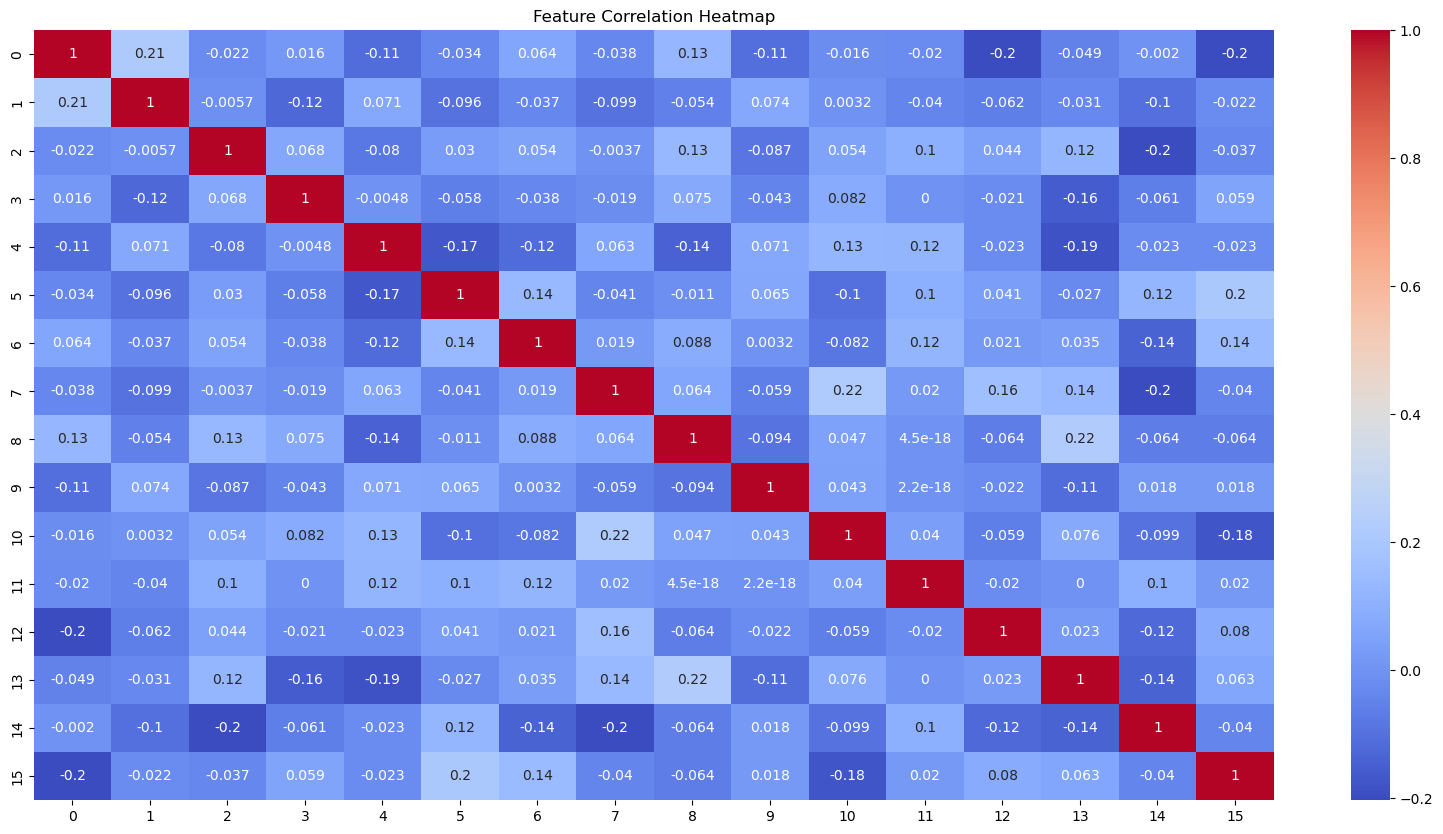

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

#corr_matrix = measurement_df.corr(method=pointbiserialr)
corr_matrix = np.corrcoef(X_train.T)
#corr_matrix = measurement_df.corr()

# Heatmap
plt.figure(figsize=(20,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

# Pair Plot
#sns.pairplot(measurement_df, hue="sink")
#plt.show()

In [6]:
mean_corr = measurement_df.corr().drop(columns=["y"], index=["y"]).abs().mean().mean()
mean_corr
target_corr = measurement_df.corr()["y"].abs()
selected_features = target_corr[target_corr > mean_corr].index.tolist()
selected_features.remove("y")
print("Selected Features:", selected_features)

Selected Features: ['adce', 'called_value_propagation', 'inline', 'instcombine', 'ipsccp', 'jump_threading', 'licm', 'pgo_memop_opt', 'sink', 'tailcallelim']


## L1 Regularization

called_value_propagation    469.754277
pgo_memop_opt               211.299109
ipsccp                      209.831556
inline                      179.861019
adce                        121.859561
tailcallelim                 90.627981
sink                         79.418933
licm                         64.691891
jump_threading               60.173338
instcombine                  53.628251
gvn                          34.872960
basicaa                      27.728684
ee_instrument                25.988991
mergereturn                  21.944306
simplifycfg                  21.236682
sccp                         18.624883
dtype: float64


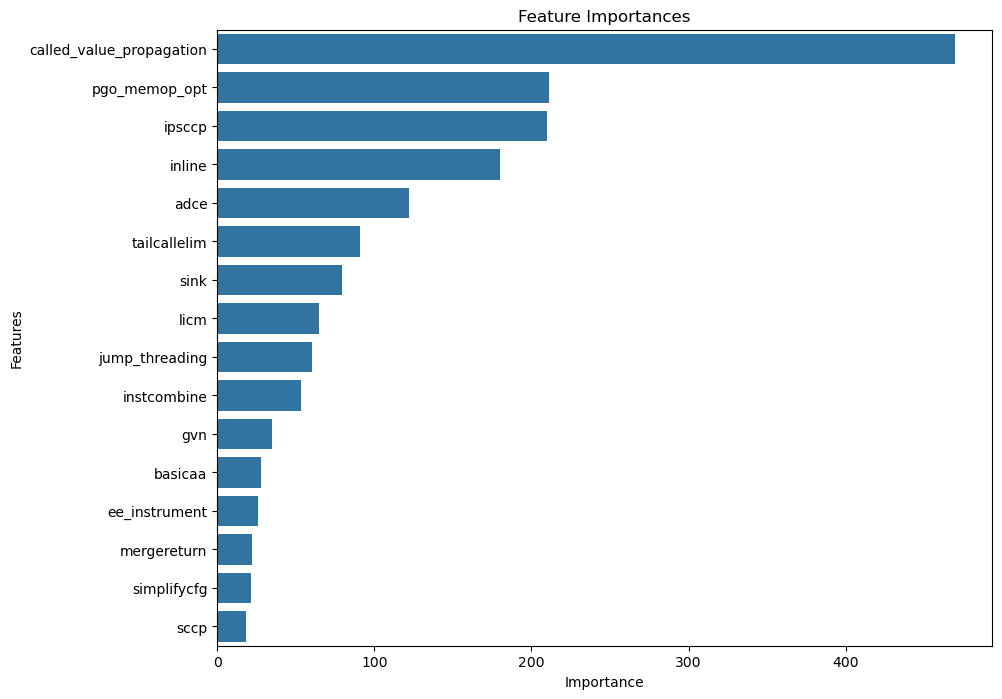

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV

# Fit the model
#model = LassoCV(alphas=np.logspace(-2, 4, 1000))
model = RidgeCV()
model.fit(X_train, y_train)  # X is your features, y is your target variable

# Feature importances are the absolute values of the coefficients
feature_importances = pd.Series(abs(model.coef_), index=feature_names)

# Assuming 'feature_importances' is a dictionary or a Pandas Series 
# with feature names as keys and their importance (e.g., correlation coefficient) as values
# Example: feature_importances = {'feature1': 0.8, 'feature2': 0.75, ...}

# Convert to Pandas Series for easy plotting if it's not already
#feature_importances = measurement_df.corr()["y"].abs().sort_values(ascending=False)
feature_importances = pd.Series(feature_importances)

# Sort features based on importance
sorted_features = feature_importances.sort_values(ascending=False)
print(sorted_features)

# Create a bar plot
plt.figure(figsize=(10, 8))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


Applying a L2 norm (euclidian) to the features, we see a nearly logarithmic distribution -> Zipf's Law
which is good for convex optimization
-> averaging out the weights over all samples makes the performance features untractable

-> only linear speedup

## PCA
-> 

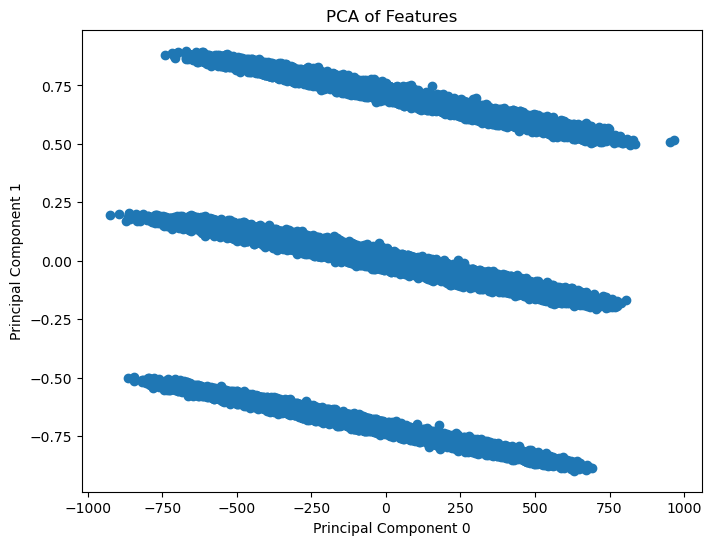

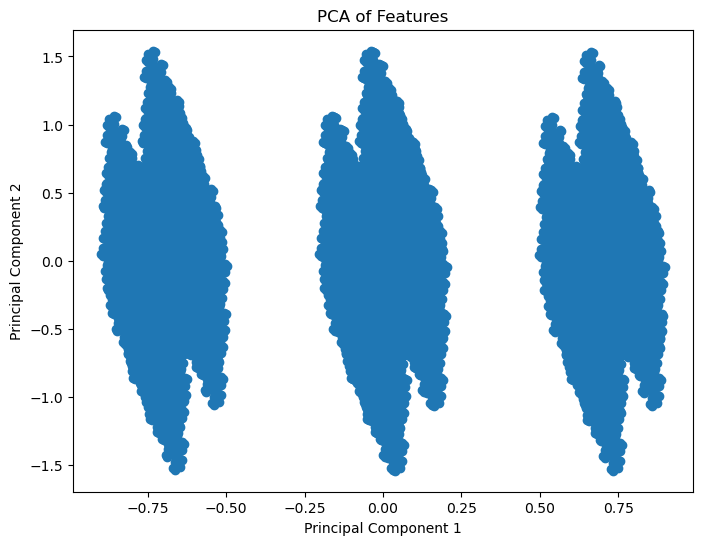

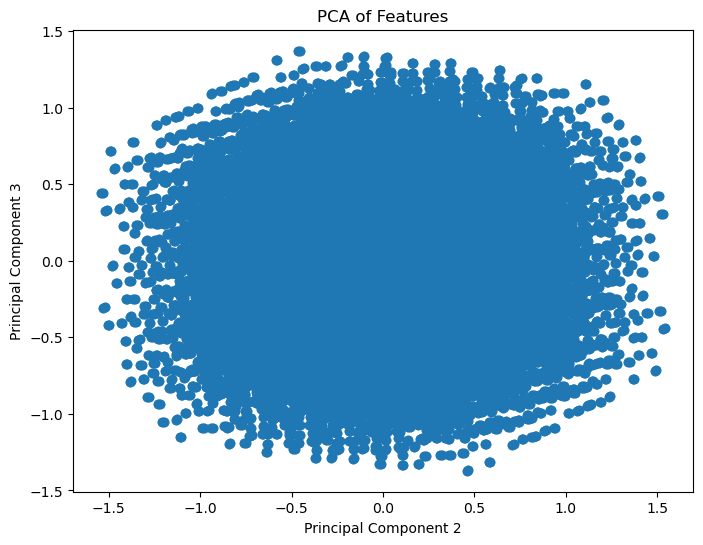

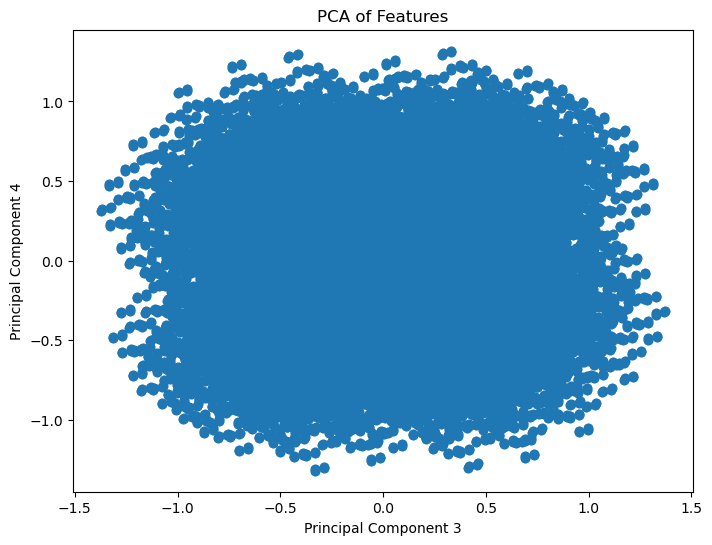

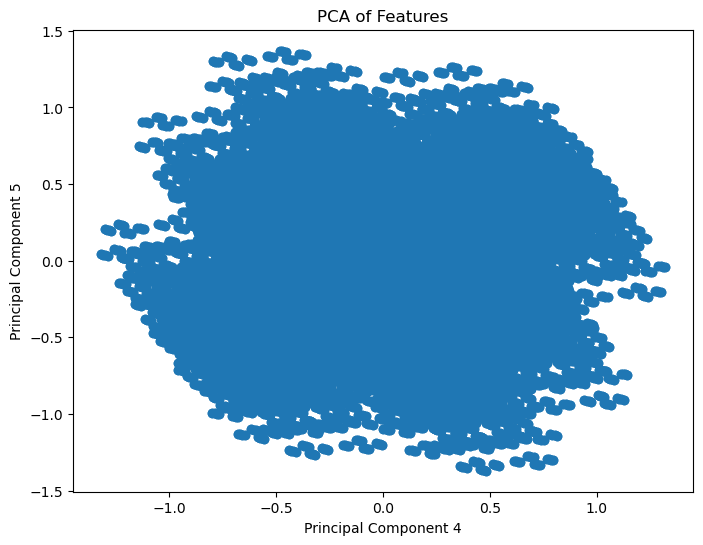

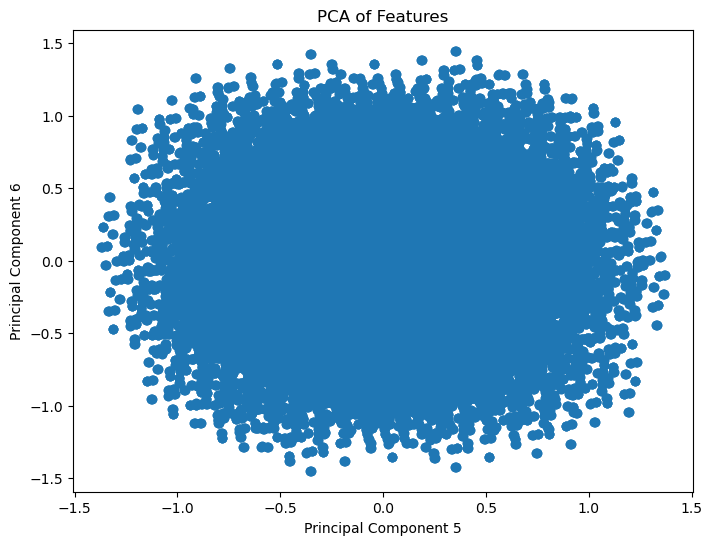

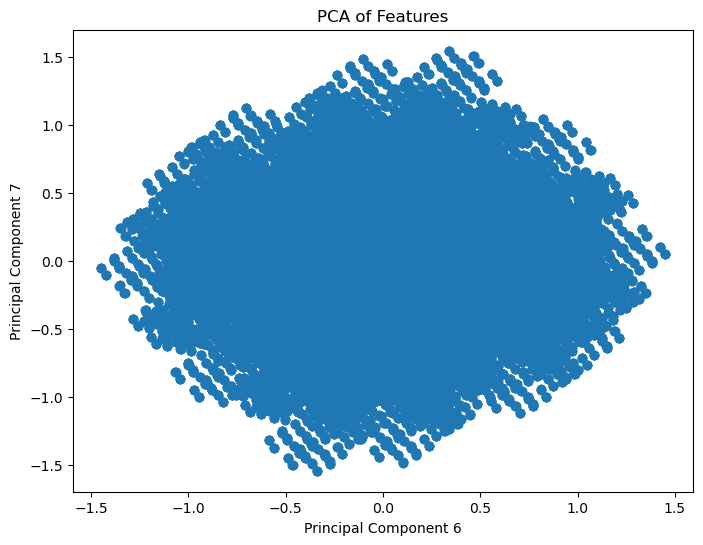

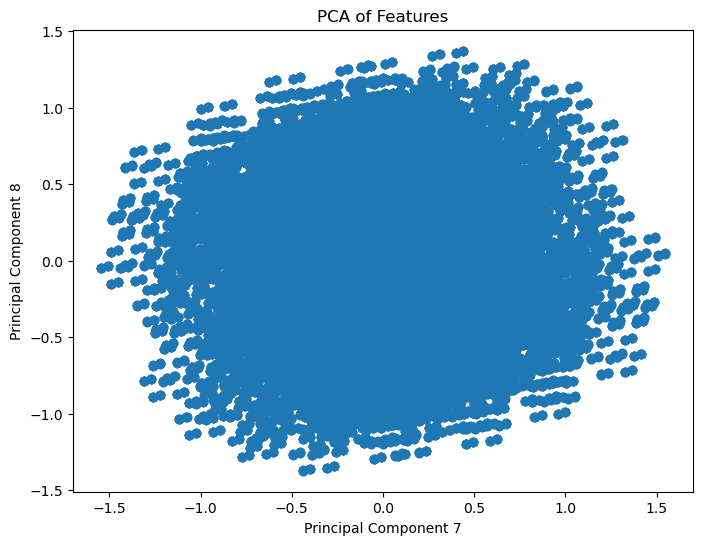

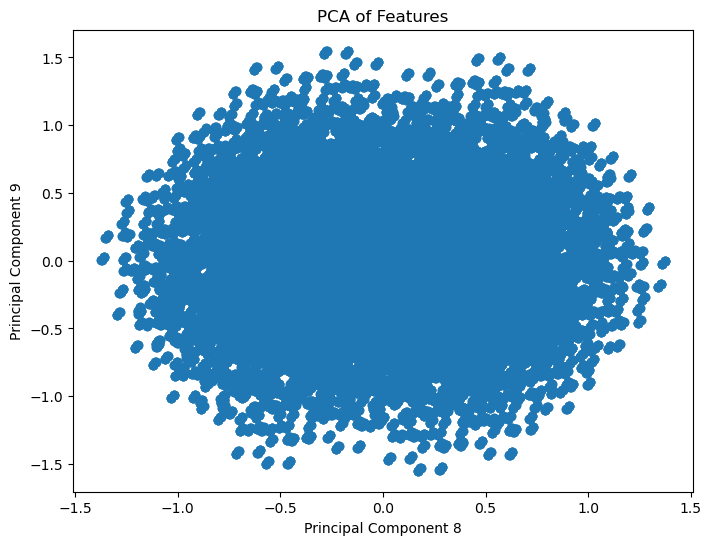

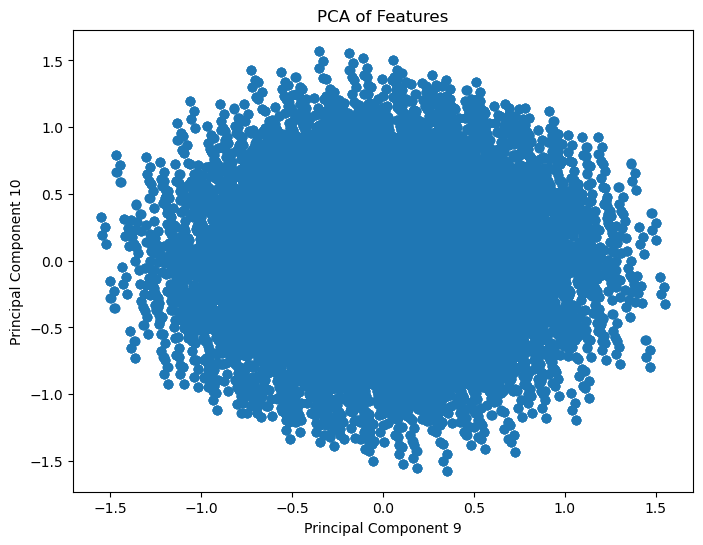

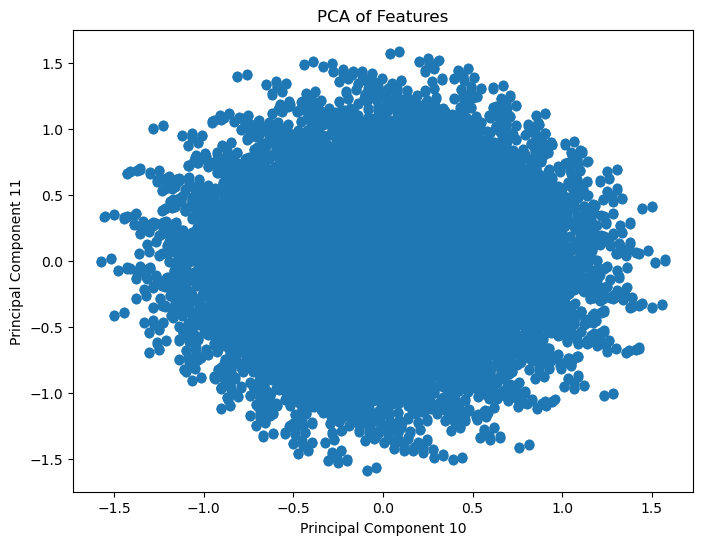

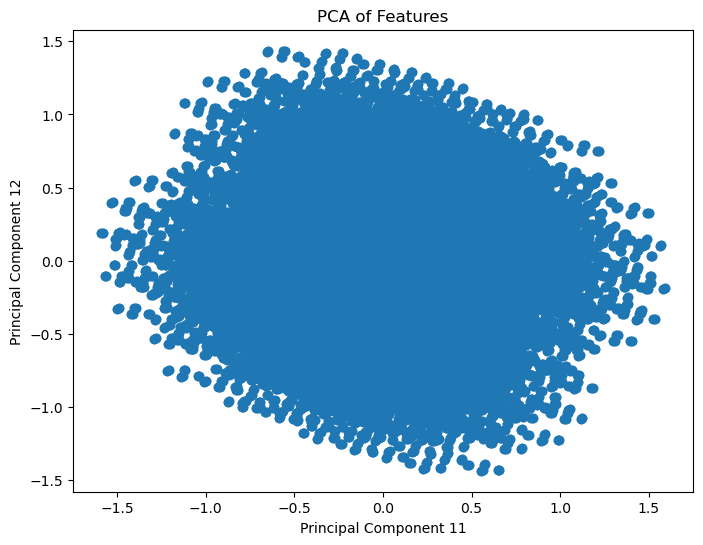

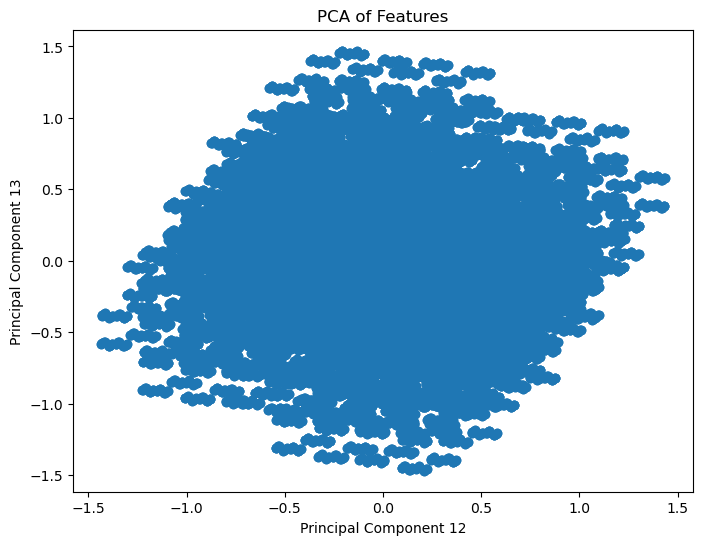

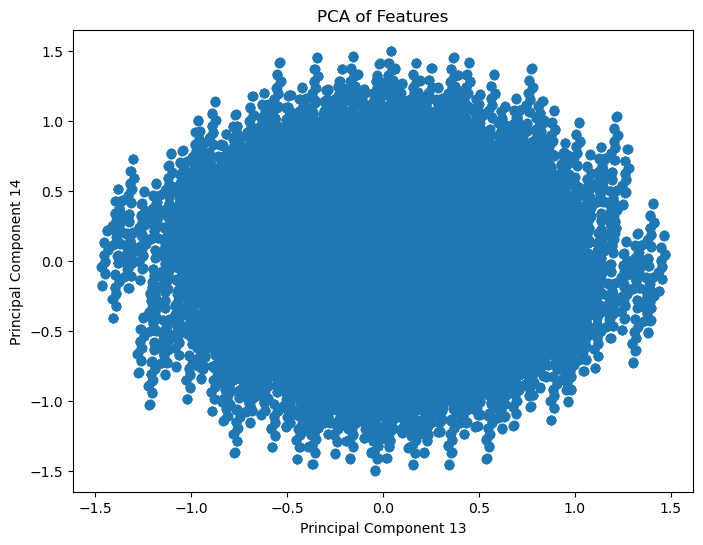

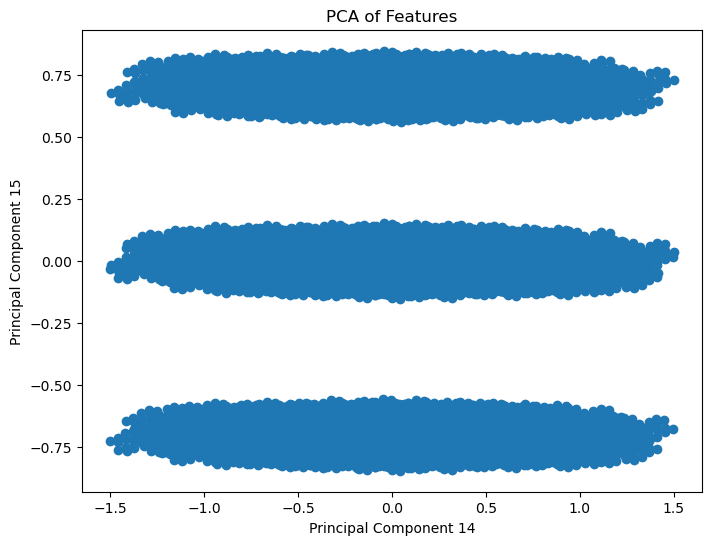

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=len(X_train.T))
#reduced_features = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.fit_transform(measurement_df)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


=> We can see clearly, that some interactions are linear separable, while most of them are not, beside having distinctive shapes indicating some interaction pattern

## Clustering with a GMM

0
2
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
1
4
Initialization 0
  Iteration 10
Initialization converged: True
2
8
Initialization 0
Initialization converged: True
3
12
Initialization 0
Initialization converged: True
4
16
Initialization 0
Initialization converged: True


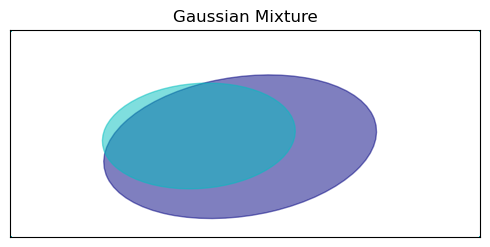

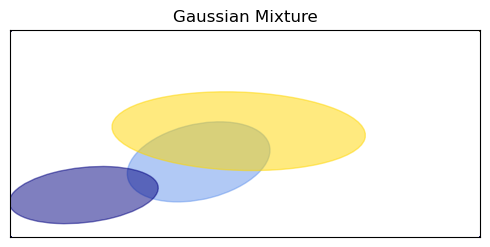

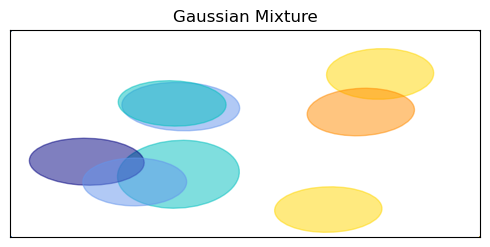

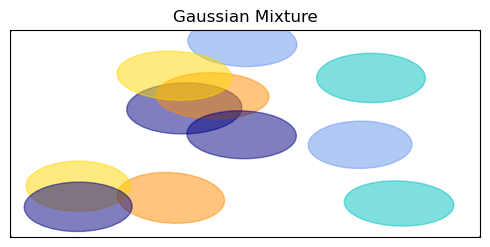

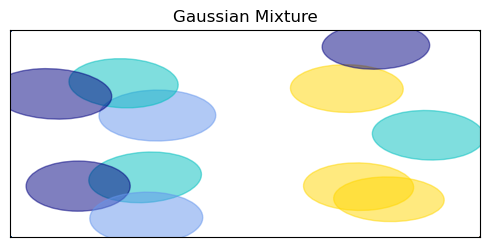

In [6]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
np.seterr('raise')

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results_(X, Y_, means, covariances, index, title):
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color, feature_name) in enumerate(zip(means, covariances, color_iter, feature_names)):
        v, w = np.linalg.eigh(covar)
        v = 2 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        #plt.text(mean[0], mean[1], feature_name, ha='center', va='center', color='black')

#    plt.xlim(-9.0, 5.0)
#    plt.ylim(-3.0, 6.0)
    plt.xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    plt.ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

def plot_samples(X, Y, n_components, index, title):
    plt.subplot(5, 1, 4 + index)
    for i, color in zip(range(n_components), color_iter):
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y == i):
            continue
        plt.scatter(X[Y == i, 0], X[Y == i, 1], 0.8, color=color)

    plt.xlim(-6.0, 4.0 * np.pi - 6.0)
    plt.ylim(-5.0, 5.0)
    plt.title(title)
    plt.xticks(())
    plt.yticks(())

#gmm = GaussianMixture(n_components=4, covariance_type="tied", tol=1e-4)
TRIALS = 5
components = [2,4,8,12,16]
gmms = {}
for i, components in enumerate(components):
    print(i)
    print(components)
    gmms[i] = BayesianGaussianMixture(weight_concentration_prior_type="dirichlet_distribution",n_components=components, covariance_type="full", verbose=1, max_iter=100000, random_state=42)
    gmms[i].fit(X_train, y_train)
    plt.figure(figsize=(5, 5))
    plt.subplots_adjust(
        bottom=0.04, top=0.95, hspace=0.2, wspace=0.05, left=0.03, right=0.97
    )
    plot_results_(X_train, gmms[i].predict(X_test), gmms[i].means_, gmms[i].covariances_, 0, "Gaussian Mixture")

-> overlapping ellipses indicate a group interaction probably with some transitivity or other non-linear behaviour
-> still not a clear metric

## Clustering with Bayesian GMM

shape estimator.means_: (16, 16)
shape estimator.covariances_: (16, 16, 16)
shape estimator.means_: (16, 16)
shape estimator.covariances_: (16, 16, 16)
shape estimator.means_: (16, 16)
shape estimator.covariances_: (16, 16, 16)
shape estimator.means_: (16, 16)
shape estimator.covariances_: (16, 16, 16)
shape estimator.means_: (16, 16)
shape estimator.covariances_: (16, 16, 16)
shape estimator.means_: (16, 16)
shape estimator.covariances_: (16, 16, 16)


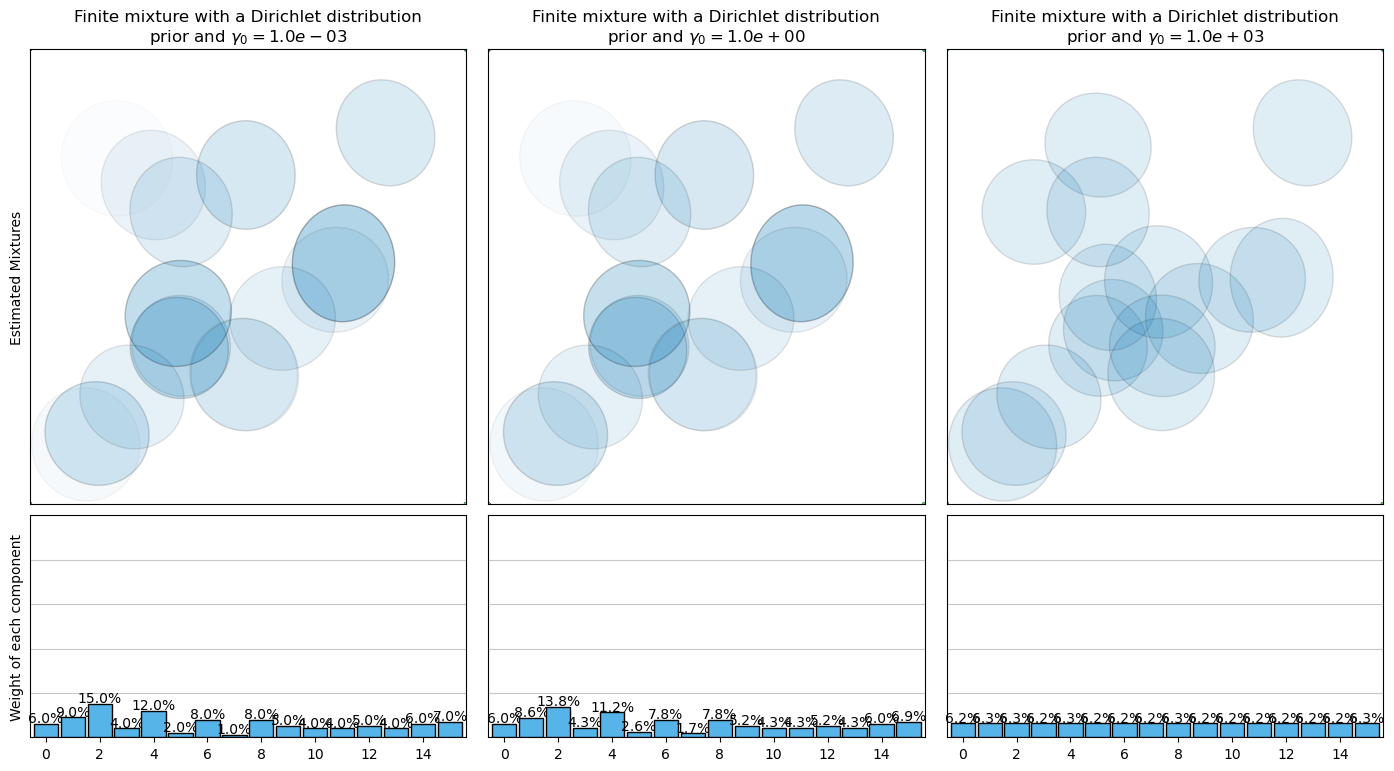

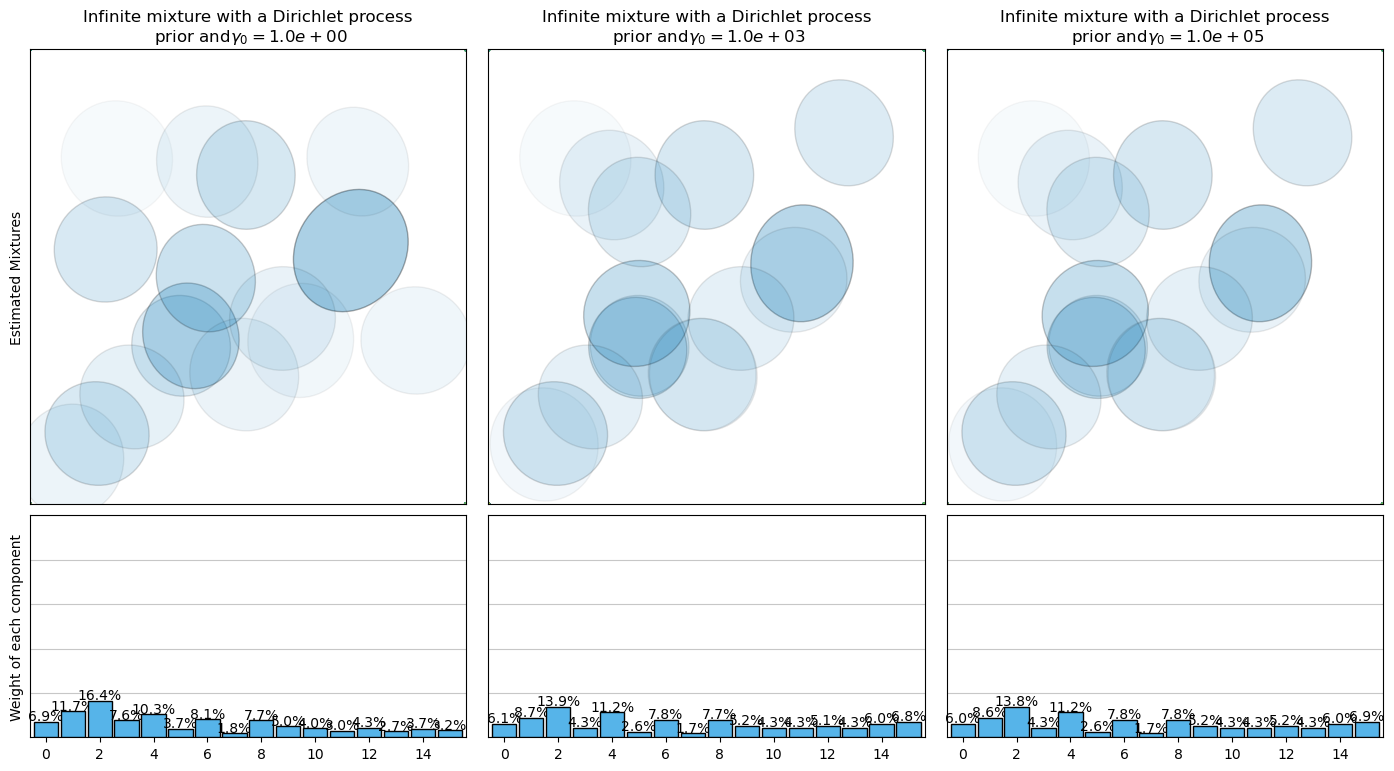

In [7]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import BayesianGaussianMixture

def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(2*weights[n])
        ell.set_facecolor("#0072B2")
        ax.add_artist(ell)


def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    #ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", color="#D55E00", alpha=0.8)
    #ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", c=y, cmap='viridis', alpha=0.8)
    ax1.scatter(X[:, 0], X[:, 15], s=5, marker="o", c=y_train, cmap='viridis', alpha=0.8)
    ax1.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
    ax1.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction="out")
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(
            k,
            w,
            width=0.9,
            color="#56B4E9",
            zorder=3,
            align="center",
            edgecolor="black",
        )
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
    ax2.set_xlim(-0.6, 2 * n_components - 0.4)
    ax2.set_ylim(0,1)
    ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax2.tick_params(axis="x", which="both", top=False)

    if plot_title:
        ax1.set_ylabel("Estimated Mixtures")
        ax2.set_ylabel("Weight of each component")


# Parameters of the dataset
random_state, n_components, n_features = 2, 8, 16
colors = np.array(["#0072B2", "#F0E442", "#D55E00", "#F0000", "#56B4E9", "#56B4E9"])

covars = np.array(
    [[[0.7, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]]]
)
samples = np.array([200, 500, 200])
means = np.array([[0.0, -0.70], [0.0, 0.0], [0.0, 0.70]])

# mean_precision_prior= 0.8 to minimize the influence of the prior
estimators = [
    (
        "Finite mixture with a Dirichlet distribution\nprior and " r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_distribution",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [0.001, 1, 1000],
    ),
    (
        "Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_process",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [1, 1000, 100000],
    ),
]

y_train = np.array(y_train, dtype=int)
# Plot results in two different figures
for title, estimator, concentrations_prior in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(
        bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
    )

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X_train)
        print(f"shape estimator.means_: {estimator.means_.shape}")
        print(f"shape estimator.covariances_: {estimator.covariances_.shape}")
        plot_results(
            plt.subplot(gs[0:2, k]),
            plt.subplot(gs[2, k]),
            estimator,
            X_train,
            y_train,
            r"%s$%.1e$" % (title, concentration),
            plot_title=k == 0,
        )

plt.show()

## Kernel PCA
- look at pairwise dimensions each

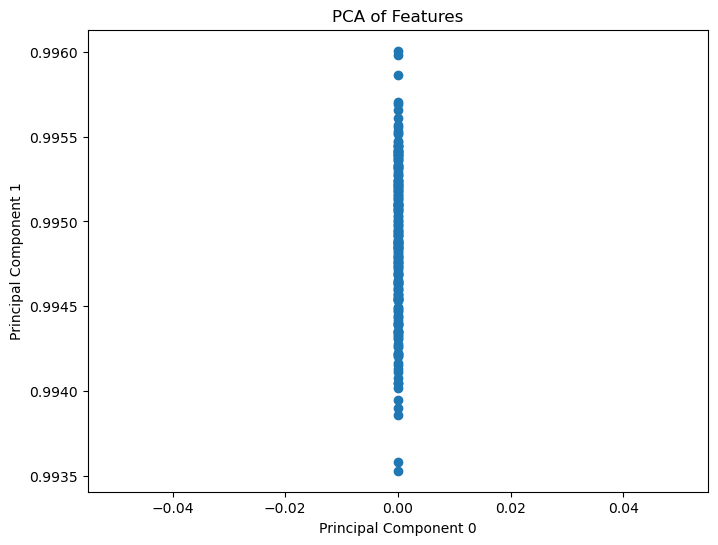

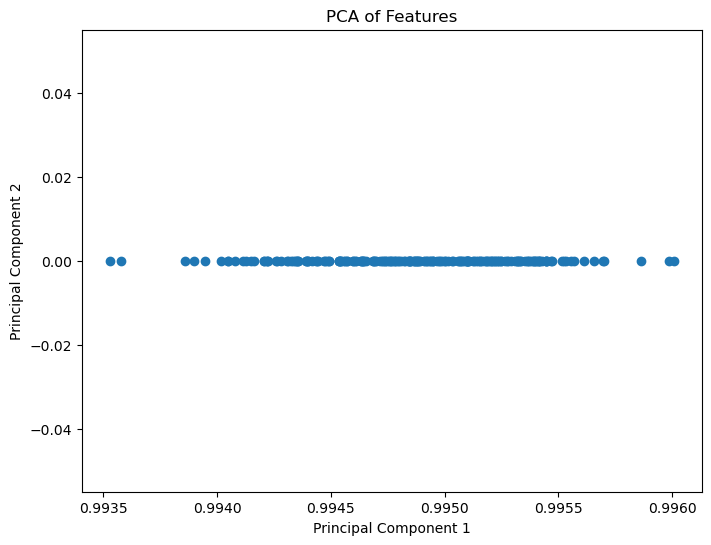

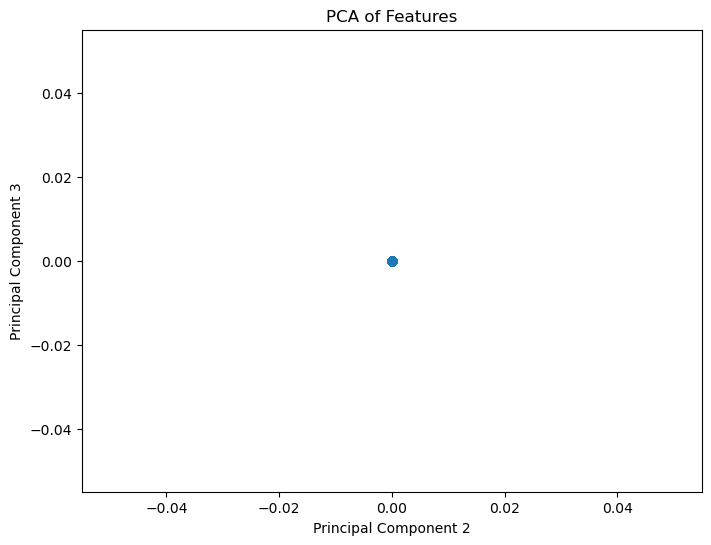

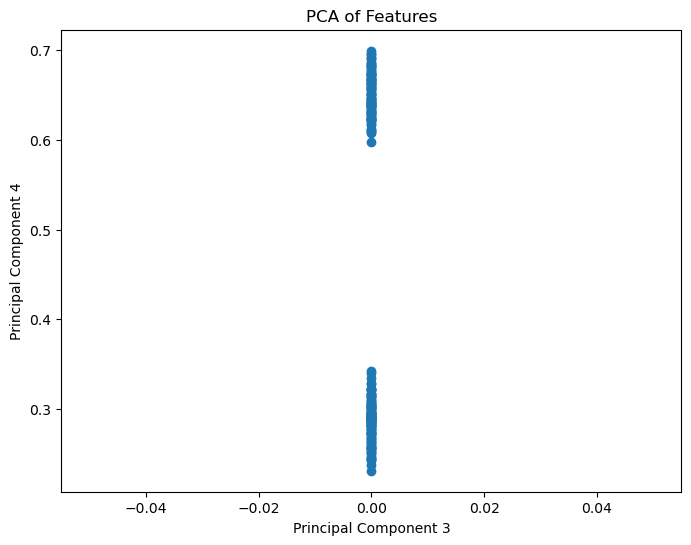

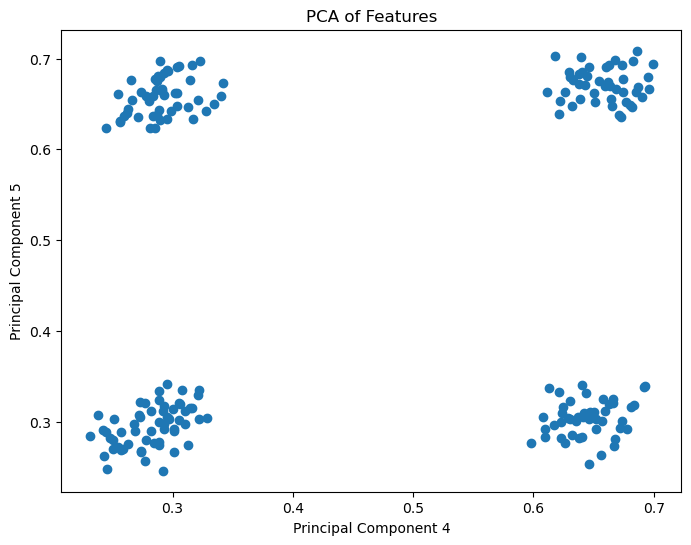

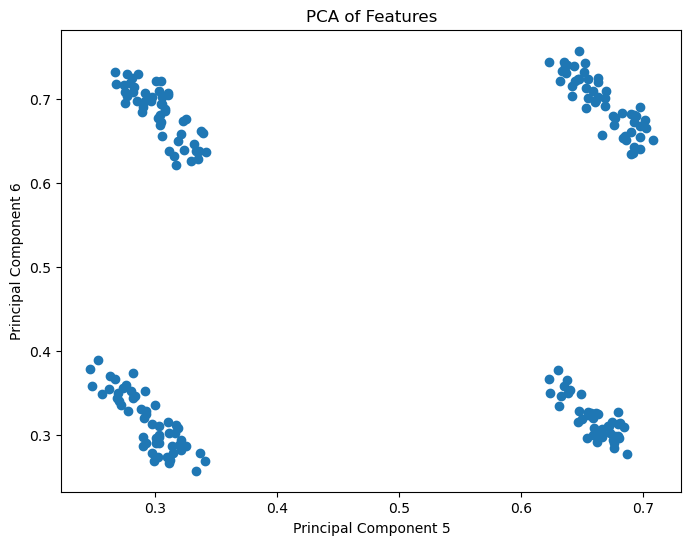

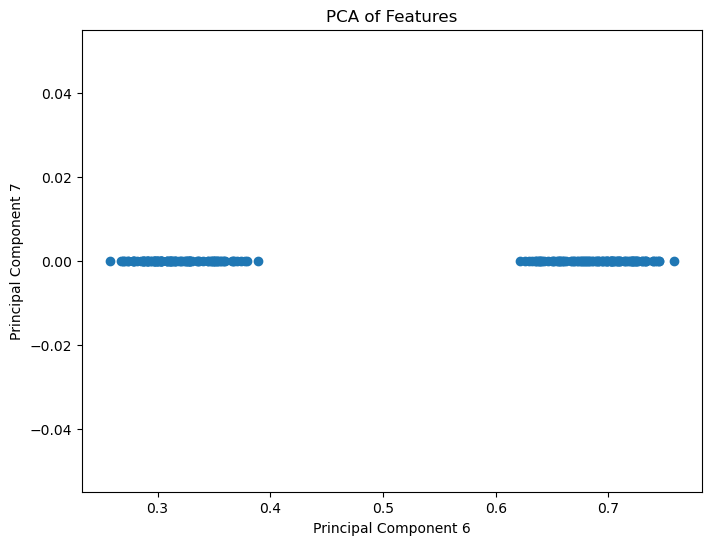

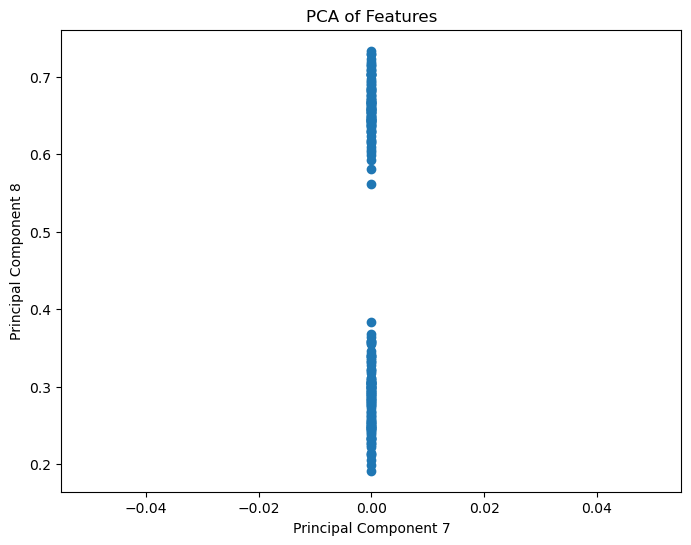

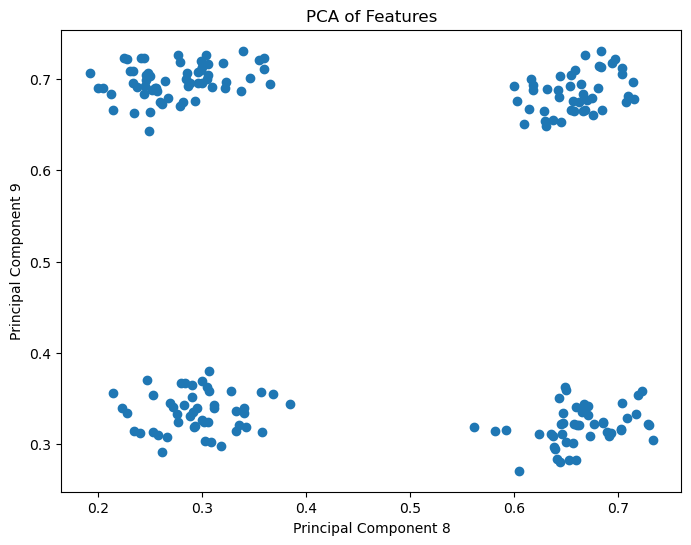

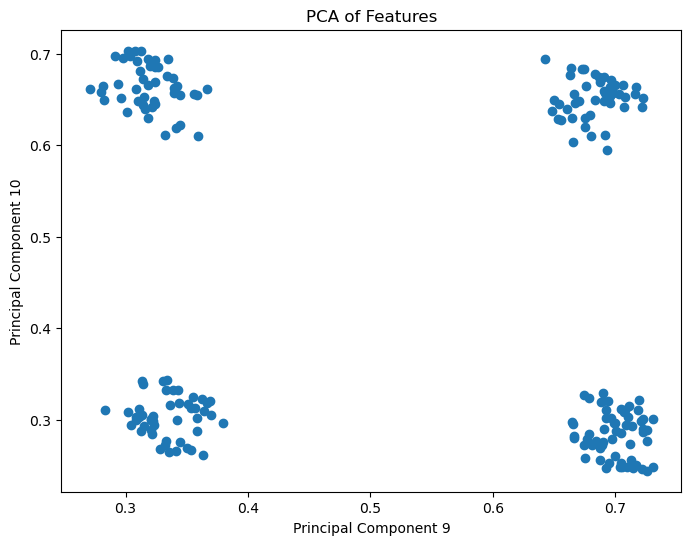

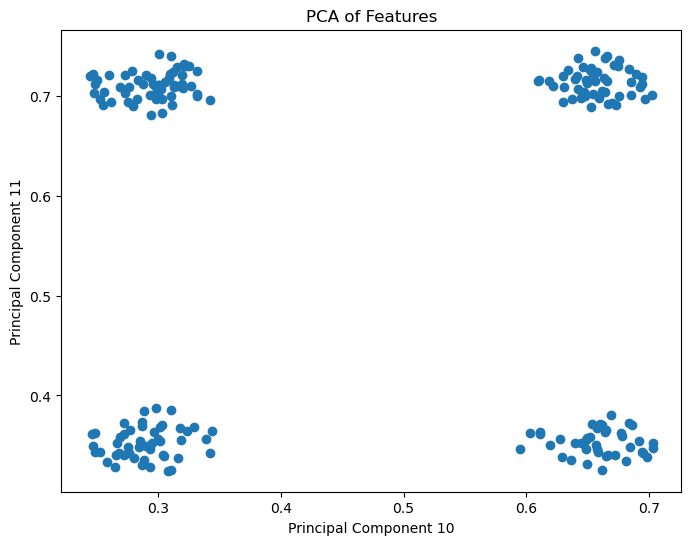

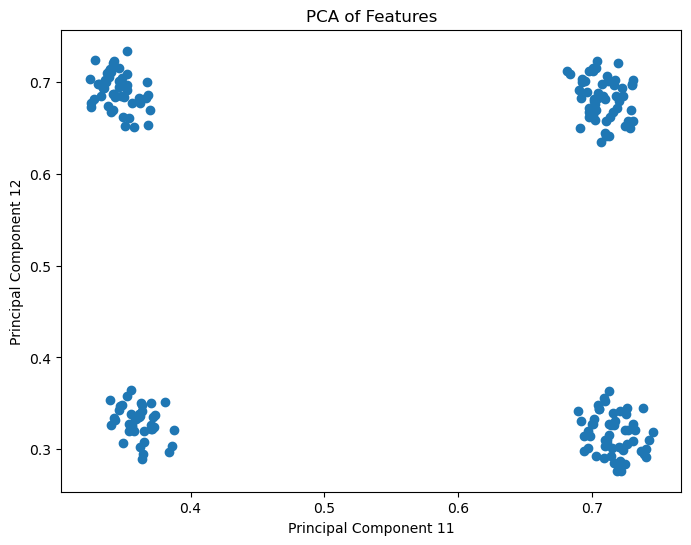

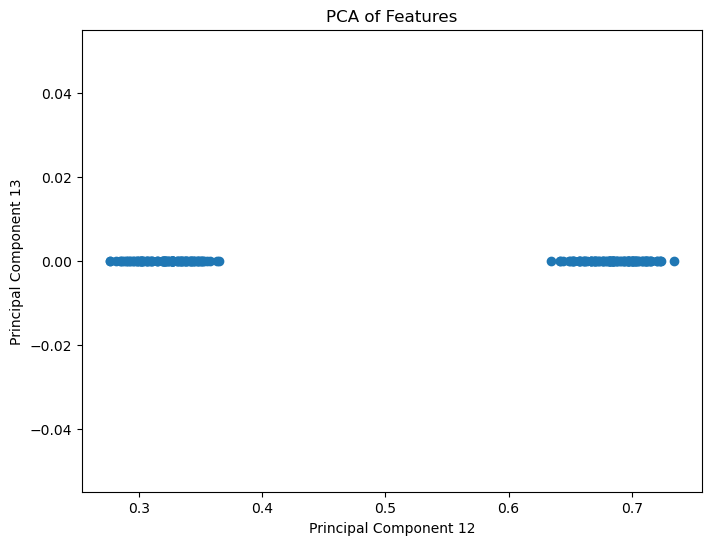

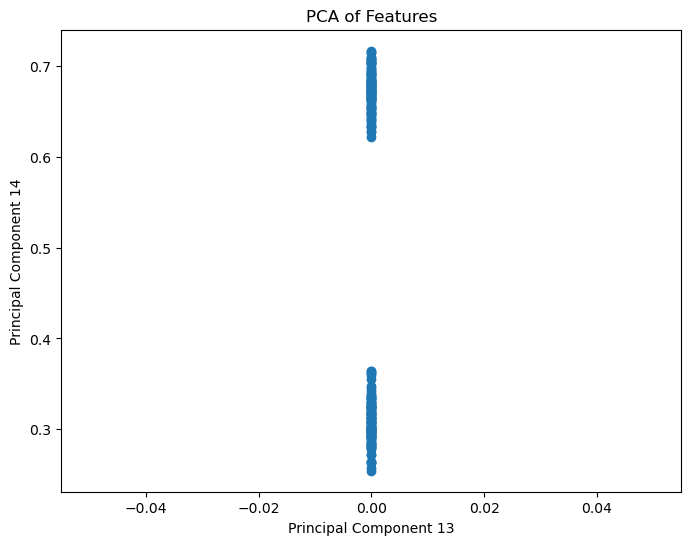

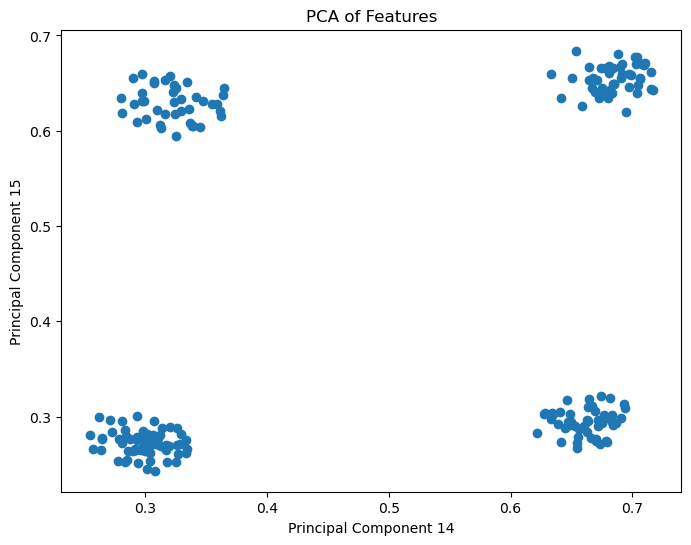

In [10]:
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt

# Perform PCA
#pca = PCA(n_components=len(X_train.T))
pca = KernelPCA(kernel="rbf", n_components=len(X_train.T), fit_inverse_transform=True)
kpca = pca.fit_transform(X=X_train,y=y_train)
reduced_features = pca.inverse_transform(kpca)

# Scatter plot of the first two principal components
for component in range(len(reduced_features.T)-1):
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, component], reduced_features[:, component+1])
        plt.xlabel(f'Principal Component {component}')
        plt.ylabel(f'Principal Component {component+1}')
        plt.title('PCA of Features')
        plt.show()


## Feature Engineering
## hierarchical constrains and views
- AVL tree inducing a ordered feature dict
## non-linear / latent feature selection
- we might want to constrain the training data to have specific feature combinations available
  - using boolean logic (CNFs/DNFs) to select feature combinations
- inspect data to detect a priori interaction patterns
    - we might want to intensify inspections on features that have a high correlation coefficient

## Polynomial Interaction Sampler
- using boolean algebra according to https://en.wikipedia.org/wiki/Zhegalkin_polynomial

### Decomposing feature strings
- imagine we have a binary encoded feature string / vector *p = 1011011* and want to know which features may interact with another
  vector *q = 1101101*, then we can just subtract q from p and look which feature combinations I have to add, to produce q:
  
  **p - q = 1000000 + 1000 + 1 - (10010 + 1110 + 10)**

- So when interested in interactions between p and q, we have to consider interactions between each substring and its opposite

### Boolean Feature Masks
- for **interactions** we concat samples with specific feature combinations **A** with a logical **AND**
- to get the **opposites not(A)**, we concat with **NAND**

def build_masks(X, conditions):
    masks = []
    for pos, opt in conditions:
        if len(X.T) < pos < 0:
            raise ValueError("pos must be a valid index of X.")
        if type(opt) != bool and opt not in [0,1]:
            raise ValueError("opt must be a \"boolean\".")
        masks.append(X[:,pos] == opt)
    return masks

def get_words(X, masks, clause="or"):
    if clause == "or":
        return X[np.logical_or(*masks)]
    elif clause == "nor":
        return X[np.logical_not(np.logical_or(*masks))]
    elif clause == "and":
        return X[np.logical_and(*masks)]
    elif clause == "nand":
        return X[np.logical_not(np.logical_and(*masks))]
    elif clause == "xor":
        return X[np.logical_xor(*masks)]


def get_interactions(X, features):
    masks = build_masks(X, features)
    print(masks)
    interactions = get_words(X, masks, clause="and")
    return interactions

def get_opposites(X, features):
    masks = build_masks(X, features)
    print(masks)
    opposites = get_words(X, masks, clause="nand")
    return opposites

feature_interactions = [(1,0),(2,1),(3,1)]
A = get_interactions(np.array(X_train), feature_interactions)
not_A = get_opposites(np.array(X_test), feature_interactions)

print(f"A: {A}\n")
print(f"not A: {not_A}")


print("sanity check, if A and not_A are distinct")
if np.size(np.setdiff1d(A,not_A)) == 0:
    print(True)
else:
    print(False)

## "biconvex Kernel sorting"

- using a proper kernel, the data gets linear separated and variance reduced

##### This indicates, that a Gaussian Process Regression for multivariate normal distribution among the features is suitable

In [ ]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import chi2_kernel, laplacian_kernel, polynomial_kernel



## Gaussian Process Regression

bayesian nonparametric model with
- Who doesn't know what the kolmogorov complexity is -> you can use a GPR for compression
- https://de.wikipedia.org/wiki/Erweiterungssatz_von_Kolmogorov
- https://de.wikipedia.org/wiki/Normierbarkeitskriterium_von_Kolmogoroff

In [4]:
print(f"X_train.shape: {X_train.shape}")
print(f"y_train.shape: {y_train.shape}")

X_train.shape: (20, 16)
y_train.shape: (20,)


As we see, the weight concentration prior is necessary to find a convex subspace where the GMM can converge to
This is reflected by the divergence of the GP model with constant mean.
By utilizing the empirical bayes method we can precalculate a weighted mean from the data and don't need to 
rescale otherwise. 
-> Can we find a kernel to estimate these kind of concentrations and overlap?


- ADD FORMULA FOR EMPIRICAL BAYES
- 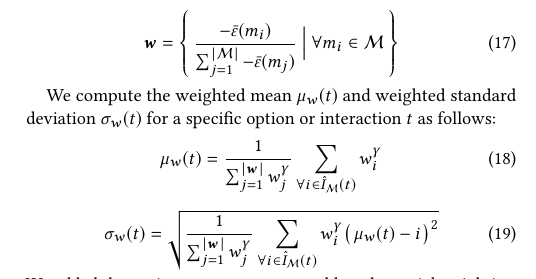

## load model

In [3]:
import torch
from domain.env import MODELDIR
from adapters.gpytorch.gp_model import SAASGP

#file_name = "SAASGP_linear_weighted_matern52_simple_ARD=False__20240208-211611" # small model good for visualization of confidence plot
#file_name = "SAASGP_linear_weighted_matern52_simple_ARD=False__20240111-165447" 
file_name = "SAASGP_linear_weighted_matern52_simple_ARD=False__20240211-165013" # 100 samples
model_file = f"{MODELDIR}/{file_name}.pth"

model = SAASGP(X_train, y_train, feature_names)
model.load_state_dict(torch.load(model_file), strict=False)


Getting priors from lin regs.
fitting 50 regressors
RidgeCV
analogue LR train set set r2 score: 0.9526687320522471
analogue LR train set set mape score: 1.8504620681528712
analogue LR train set set rmse score: 62.96953375483866

LassoCV
analogue LR train set set r2 score: 0.970662849385375
analogue LR train set set mape score: 1.446292504499015
analogue LR train set set rmse score: 49.575302569733736

Prior Spectrum Computation took 0.9333140850067139


In [4]:
model.eval()
with torch.no_grad():
    posterior = model.posterior(X_test)
    confidence_region = posterior.mvn.confidence_region()

    # create dimensional model
    dims = len(model.X.T)
    dimensional_model = {}
    for dim in range(dims):
        dimensional_model[dim] = {}
        dimensional_model[dim]["X"] = X_train[:, dim]
        dimensional_model[dim]["feature_name"] = feature_names[dim]
        dimensional_model[dim]["y"] = y_train
        dimensional_model[dim]["X_test"] = X_test[:, dim]
        dimensional_model[dim]["mean"] = posterior.mean[dim]
        dimensional_model[dim]["variance"] = posterior.variance[dim]
        dimensional_model[dim]["std"] = torch.sqrt(posterior.variance[dim])
        dimensional_model[dim]["covariance"] = posterior.covariance_matrix[dim]
        dimensional_model[dim]["lower"] = confidence_region[0][dim]
        dimensional_model[dim]["upper"] = confidence_region[1][dim]

print(f"shape of mean: {dimensional_model[0]['mean'].shape}")
print(f"shape of covariance: {dimensional_model[0]['covariance'].shape}")

shape of mean: torch.Size([20, 1])
shape of covariance: torch.Size([20, 20])


In [5]:
from adapters.gpytorch.util import decompose_matrix, get_beta, get_thetas
from domain.feature_model.feature_modeling import inverse_map
import numpy as np

CONFIDENCE = 0.95

U, lam, V = decompose_matrix(dimensional_model[0]["covariance"]) # example for first dimension
explained_var = np.cumsum(np.array(lam) / np.sum(np.array(lam)))
p = len(model.X.T)
# estimate, how much of the explained variance is explained by p components
p_explained_var = explained_var[p - 1]
print(f"{p_explained_var}.2f of the variance is explained by {p} components (the base features)")
q = np.where(explained_var >= CONFIDENCE)[0][0] + 1 # number of principal components to explain confidential proportion of variance
qq = next(x[0] for x in enumerate(explained_var) if x[1] > CONFIDENCE) + 1
qqq = next(i + 1 for i, var in enumerate(explained_var) if var >= CONFIDENCE)
Lambda = np.diag(np.sort(lam)[::-1])[:q] # diagonal matrix with first q eigenvalues 
U = U[:, :q] # first q columns
B = inverse_map(model.X.T, U)
Laplace_approximation = B @ B.T
thetas = get_thetas(dimensional_model[0]["covariance"], q)
betas = get_beta(B, thetas)

X is full rank and square. Rank(X) = 20
0.9838929759728934.2f of the variance is explained by 16 components (the base features)
X is full rank and square. Rank(X) = 20
i = 0
B.shape = torch.Size([16, 13])
thetamat.shape = torch.Size([20, 13])
betamat[:, i] = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
betamat[:, i].shape = (16,)
thetamat[i, :] = tensor([-11825.4937, -10035.3039,  -4789.0077,  -6978.7576,  -1406.5704,
          2056.2811, -10003.9039, -14182.9776,  -2243.8676, -10215.9174,
          5483.4235,   6132.3023,   -912.0054], dtype=torch.float64)
thetamat[i, :].shape = torch.Size([13])


/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/adapters/gpytorch/util.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/domain/feature_model/feature_modeling.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)
/home/immanuel/Dokumente/Master Thesis/dev/energy-influence-model-structure-uncertainty/domain/feature_model/feature_modeling.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

## dimension wise interactions

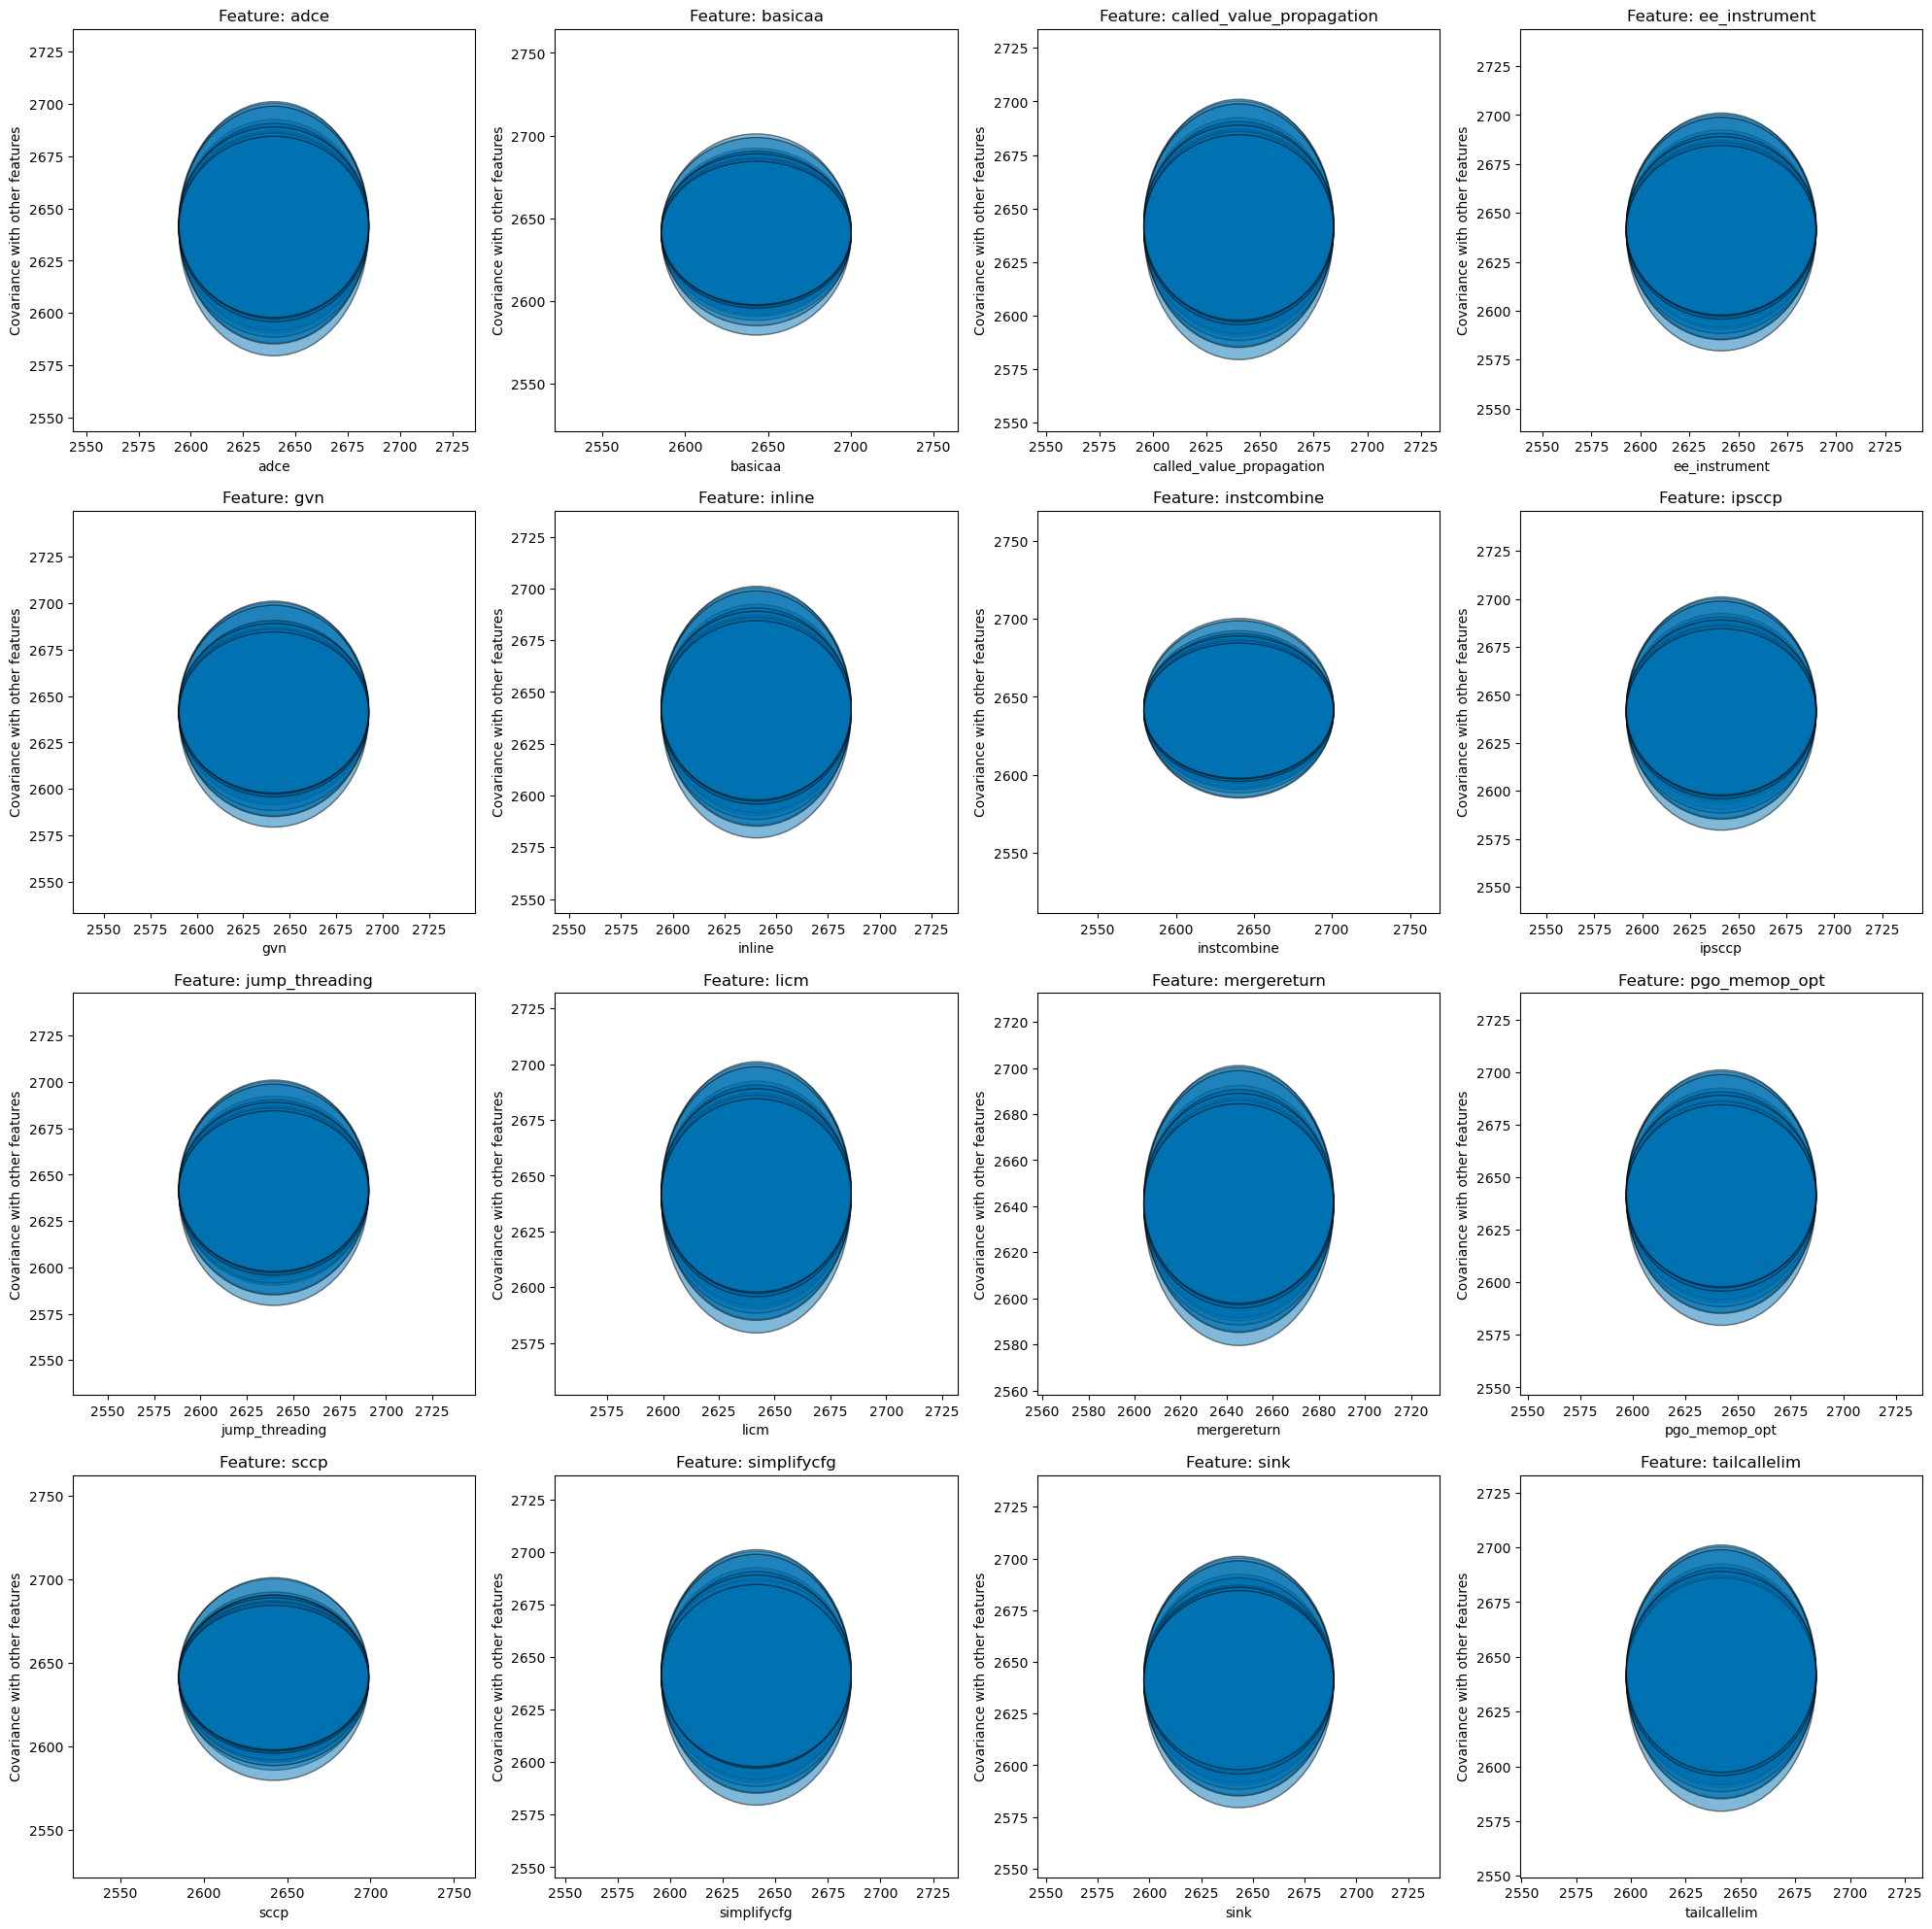

In [79]:
def plot_gp_confidence_intervals(ax, X, mean, covariance, title="GP Predictions"):
    # Assuming X is 2D for plotting and mean, covariance are for these dimensions
    std_dev = torch.sqrt(torch.diag(covariance))  # Standard deviation for confidence intervals
    
    ax.fill_between(X[:, 0], mean[:, 0] - 2 * std_dev, mean[:, 0] + 2 * std_dev, alpha=0.2)
    ax.plot(X[:, 0], mean[:, 0], 'r')  # Mean prediction
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Prediction")

def plot_ellipses_in_grid(dimensional_model, rows=2, edge_color='black', fill_color='#0072B2', fill_alpha=0.5):
    """
    Plots ellipses representing covariance for each feature against all other features in a grid layout.
    
    Args:
    - dimensional_model: Dictionary containing model information for each dimension.
    - rows: Number of rows in the grid of subplots.
    - edge_color: Color of the ellipse edge.
    - fill_color: Fill color of the ellipse.
    - fill_alpha: Alpha value for the fill color to control transparency.
    """
    num_features = len(dimensional_model)
    cols = (num_features + rows - 1) // rows  # Calculate the required number of columns for the grid
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows), squeeze=False)
    
    for i in range(num_features):
        row, col = divmod(i, cols)
        ax = axes[row, col]
        feature_name_i = dimensional_model[i]["feature_name"]
        mean_i = dimensional_model[i]["mean"].mean().item()
        variance_i = dimensional_model[i]["variance"].median().item()
        
        for j in range(num_features):
            if i != j:
                feature_name_j = dimensional_model[j]["feature_name"]
                mean_j = dimensional_model[j]["mean"].mean().item()
                variance_j = dimensional_model[j]["variance"].median().item()
                
                cov_matrix_2x2 = np.array([[variance_i, 0], [0, variance_j]])
                eig_vals, eig_vecs = np.linalg.eigh(cov_matrix_2x2)
                angle = np.degrees(np.arctan2(eig_vecs[1, 0], eig_vecs[0, 0]))
                width, height = 2 * np.sqrt(2) * np.sqrt(eig_vals)
                
                ellipse = mpl.patches.Ellipse(xy=(mean_i, mean_j), width=width, height=height, angle=angle,
                                          edgecolor=edge_color, facecolor=fill_color, alpha=fill_alpha)
                ax.add_patch(ellipse)
        
        ax.set_xlim(mean_i - 3 * np.sqrt(variance_i), mean_i + 3 * np.sqrt(variance_i))
        ax.set_ylim(mean_i - 3 * np.sqrt(variance_i), mean_i + 3 * np.sqrt(variance_i))
        ax.set_xlabel(feature_name_i)
        ax.set_ylabel('Covariance with other features')
        ax.set_title(f'Feature: {feature_name_i}')
        ax.set_aspect('equal')
    
    # Turn off any unused subplots
    for i in range(num_features, rows * cols):
        row, col = divmod(i, cols)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


#plot_gp_confidence_intervals(ax, X_test, dimensional_model[0]["mean"], dimensional_model[0]["covariance"])

plot_ellipses_in_grid(dimensional_model, rows=4)

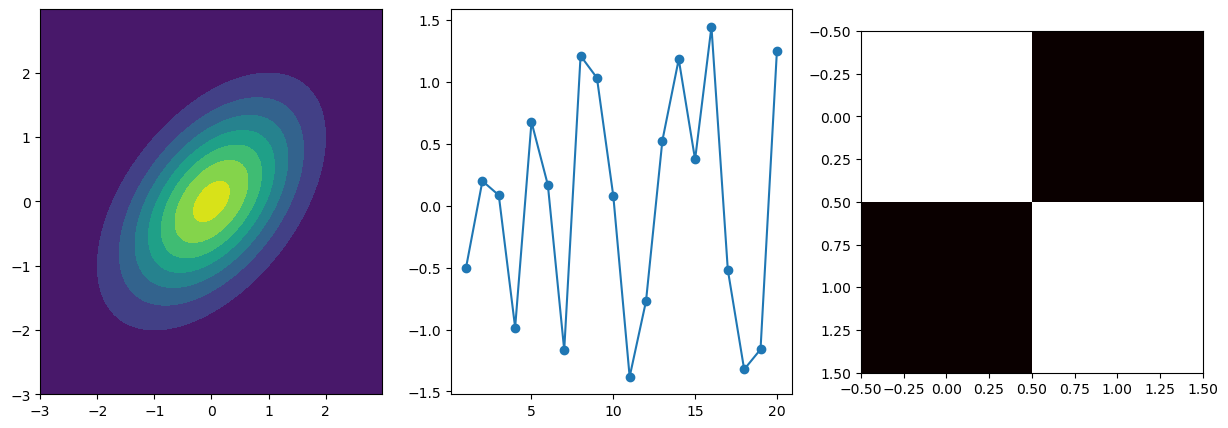

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# For reproducibility
np.random.seed(42)

# Example mean and covariance for a 2D Gaussian
mu = np.array([0, 0])
cov = np.array([[1, 0.5], [0.5, 1]])

# Create grid and multivariate normal
x, y = np.mgrid[-3:3:.01, -3:3:.01]
pos = np.dstack((x, y))
rv = multivariate_normal(mu, cov)

# Make the plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Contour plot
ax[0].contourf(x, y, rv.pdf(pos))

# Line plot for a sample path
t = np.linspace(1, 20, 20)
y_sample = np.random.multivariate_normal(mu, cov, size=t.shape[0])
ax[1].plot(t, y_sample[:, 1], '-o')

# Heatmap of the covariance matrix
ax[2].imshow(cov, cmap='hot', interpolation='nearest')

plt.show()



## Inspecting the covariance matrix

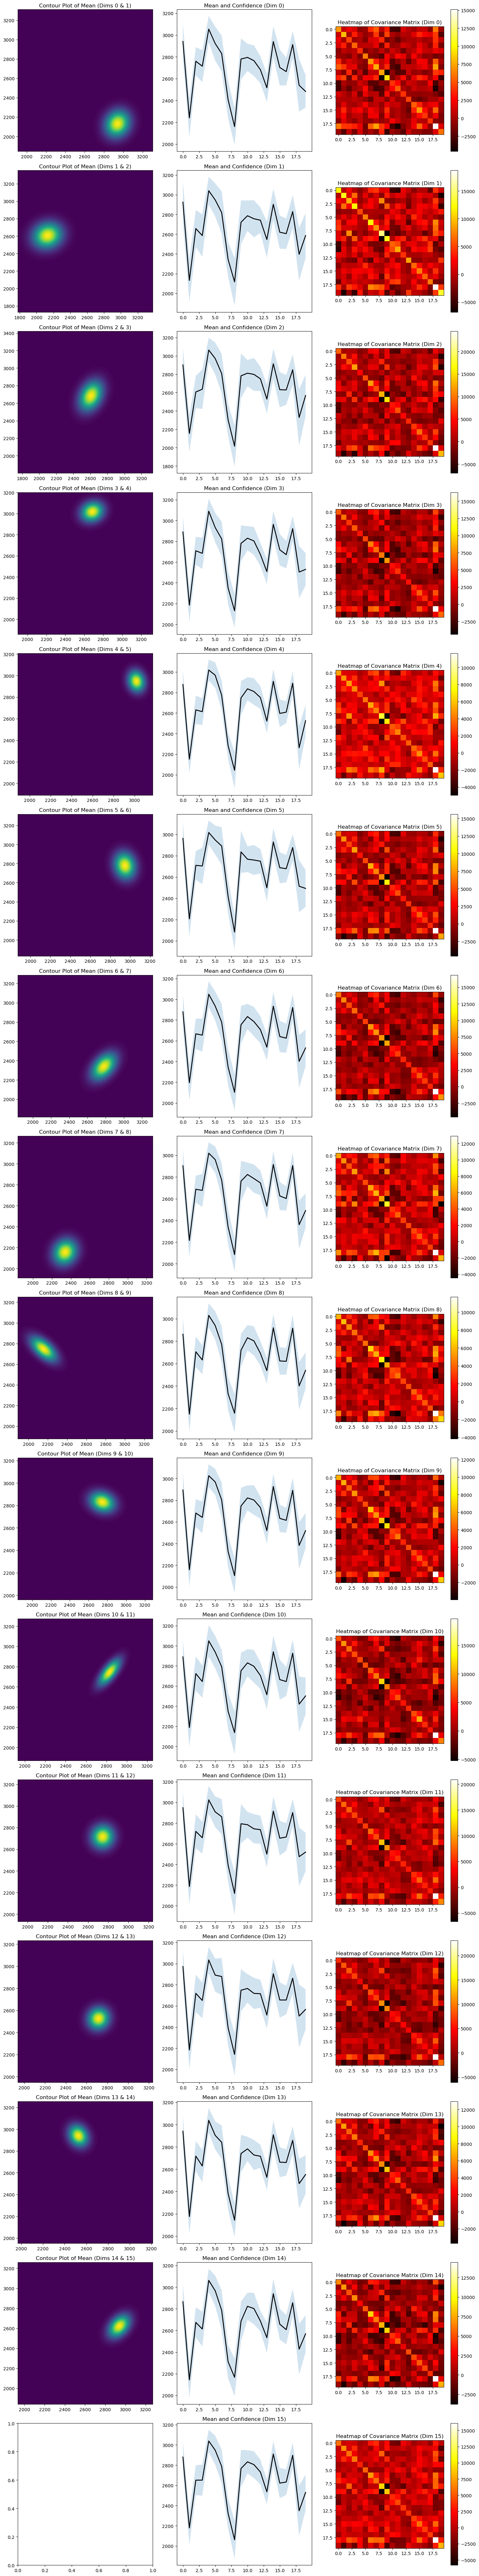

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch

# Assuming dimensional_model is defined with "mean" and "covariance" for each dimension

# Number of dimensions in your model
num_dims = len(dimensional_model)

# Prepare the figure with a grid of subplots
fig, axs = plt.subplots(num_dims, 3, figsize=(15, 5 * num_dims))

# Iterate over each dimension pair
for i in range(num_dims):
    # Mean and covariance for the current dimension
    mean_i = dimensional_model[i]["mean"].squeeze(-1).numpy()  # Squeeze to make it 1D
    cov_i = dimensional_model[i]["covariance"].numpy()

    # Contour plot for the mean of two dimensions
    if i < num_dims - 1:  # Ensure there is a next dimension to pair with
        mean_j = dimensional_model[i + 1]["mean"].squeeze().numpy()
        
        # Choose appropriate grid limits
        grid_x_min, grid_x_max = mean_i.min() - 3 * np.sqrt(cov_i[i, i]), mean_i.max() + 3 * np.sqrt(cov_i[i, i])
        grid_y_min, grid_y_max = mean_j.min() - 3 * np.sqrt(cov_i[i + 1, i + 1]), mean_j.max() + 3 * np.sqrt(cov_i[i + 1, i + 1])
        
        xi, yi = np.meshgrid(np.linspace(grid_x_min, grid_x_max, 100), np.linspace(grid_y_min, grid_y_max, 100))
        
        # Extract the covariance entries for just these two dimensions
        cov_ij = np.array([
            [cov_i[i, i], cov_i[i, i + 1]],
            [cov_i[i + 1, i], cov_i[i + 1, i + 1]]
        ])
        
        # Create a bivariate normal distribution
        rv_ij = multivariate_normal([mean_i[i], mean_j[i + 1]], cov_ij)
        
        # Compute the PDF over the grid and plot the contour
        zi = rv_ij.pdf(np.dstack((xi, yi)))
        axs[i, 0].contourf(xi, yi, zi, levels=100)
        axs[i, 0].set_title(f'Contour Plot of Mean (Dims {i} & {i+1})')


    # Line plot for the mean and confidence interval of the current dimension
    std_dev_i = np.sqrt(np.diag(cov_i))
    axs[i, 1].plot(mean_i, 'k-', lw=2)
    axs[i, 1].fill_between(range(len(mean_i)), mean_i - 1.96 * std_dev_i, mean_i + 1.96 * std_dev_i, alpha=0.2)
    axs[i, 1].set_title(f'Mean and Confidence (Dim {i})')

    # Heatmap of the covariance matrix for the current dimension
    im = axs[i, 2].imshow(cov_i, cmap='hot', interpolation='nearest')
    fig.colorbar(im, ax=axs[i, 2])
    axs[i, 2].set_title(f'Heatmap of Covariance Matrix (Dim {i})')

# Adjust the layout to prevent overlap
plt.tight_layout()
plt.show()


## Inspecting the precision matrix

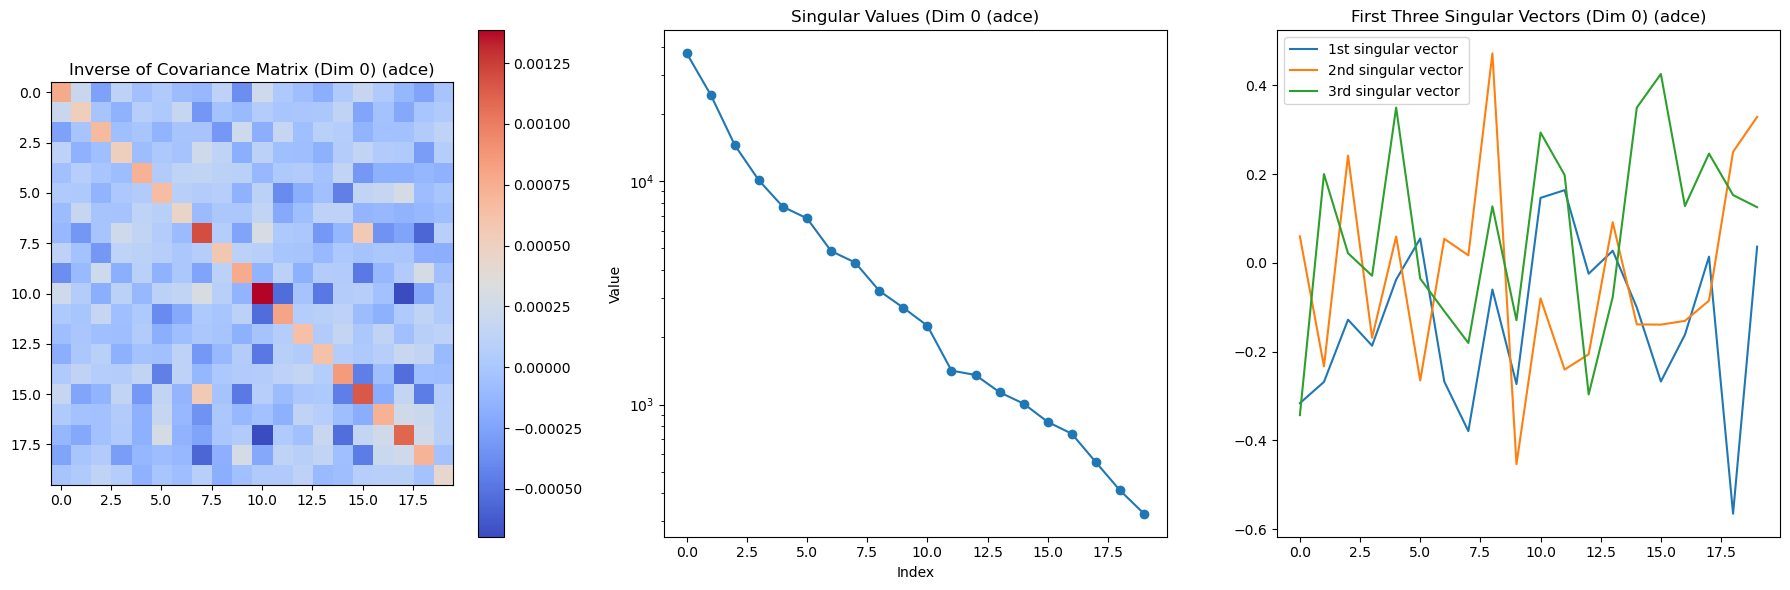

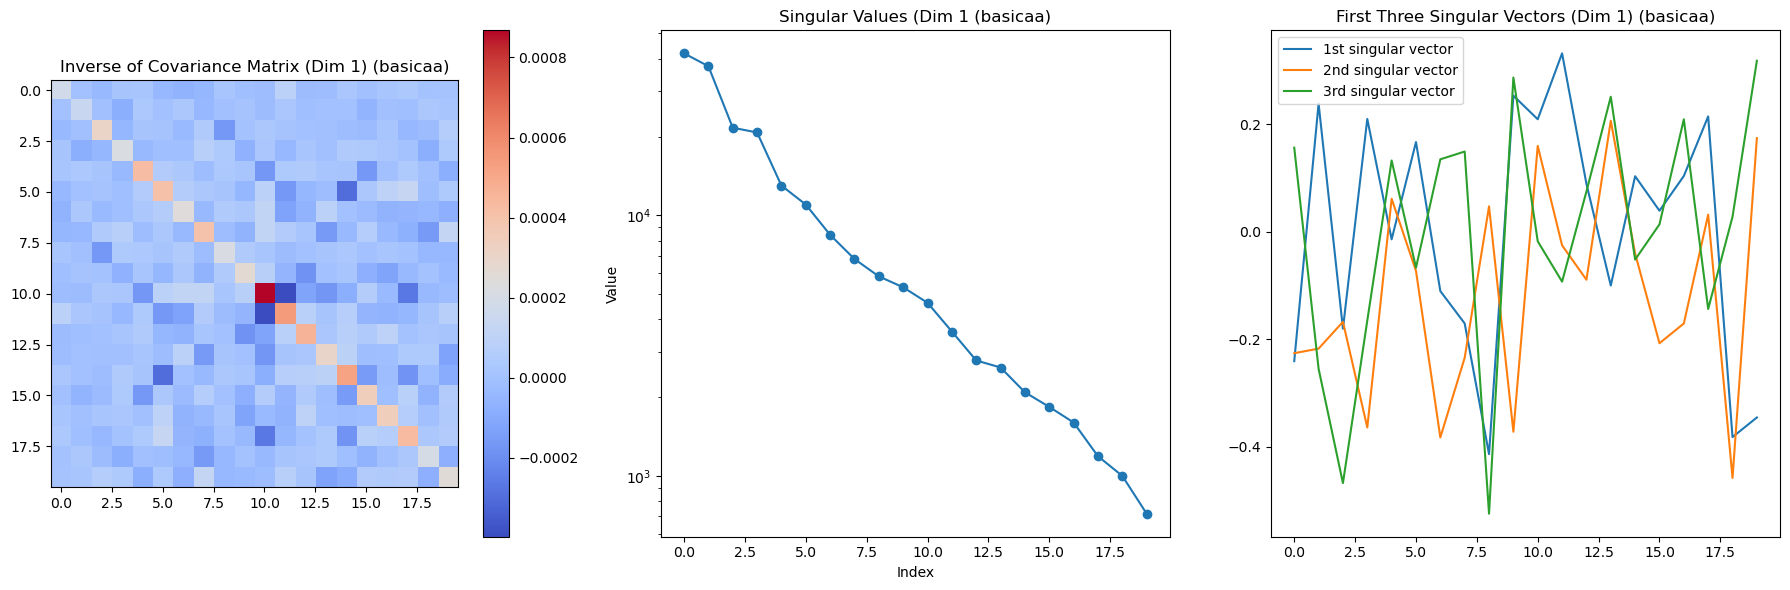

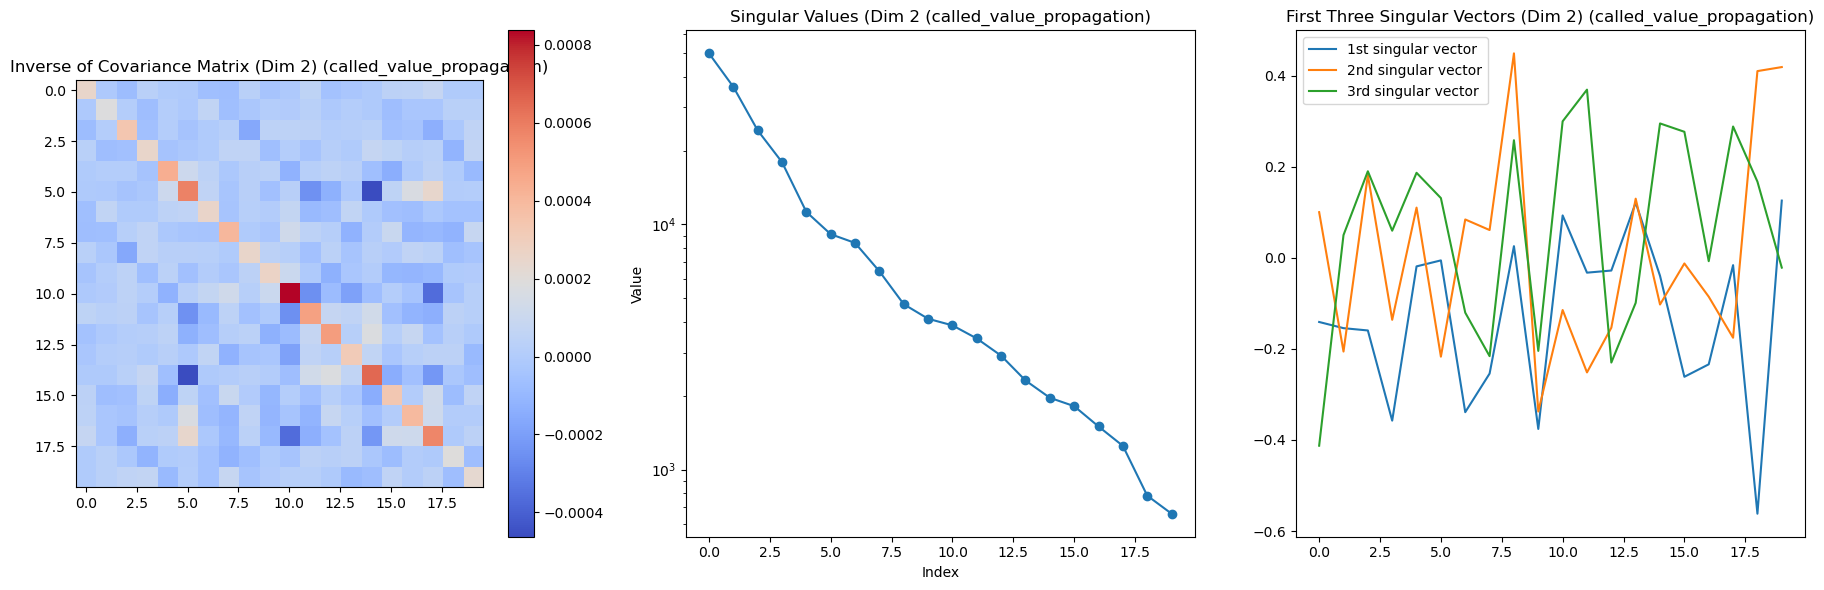

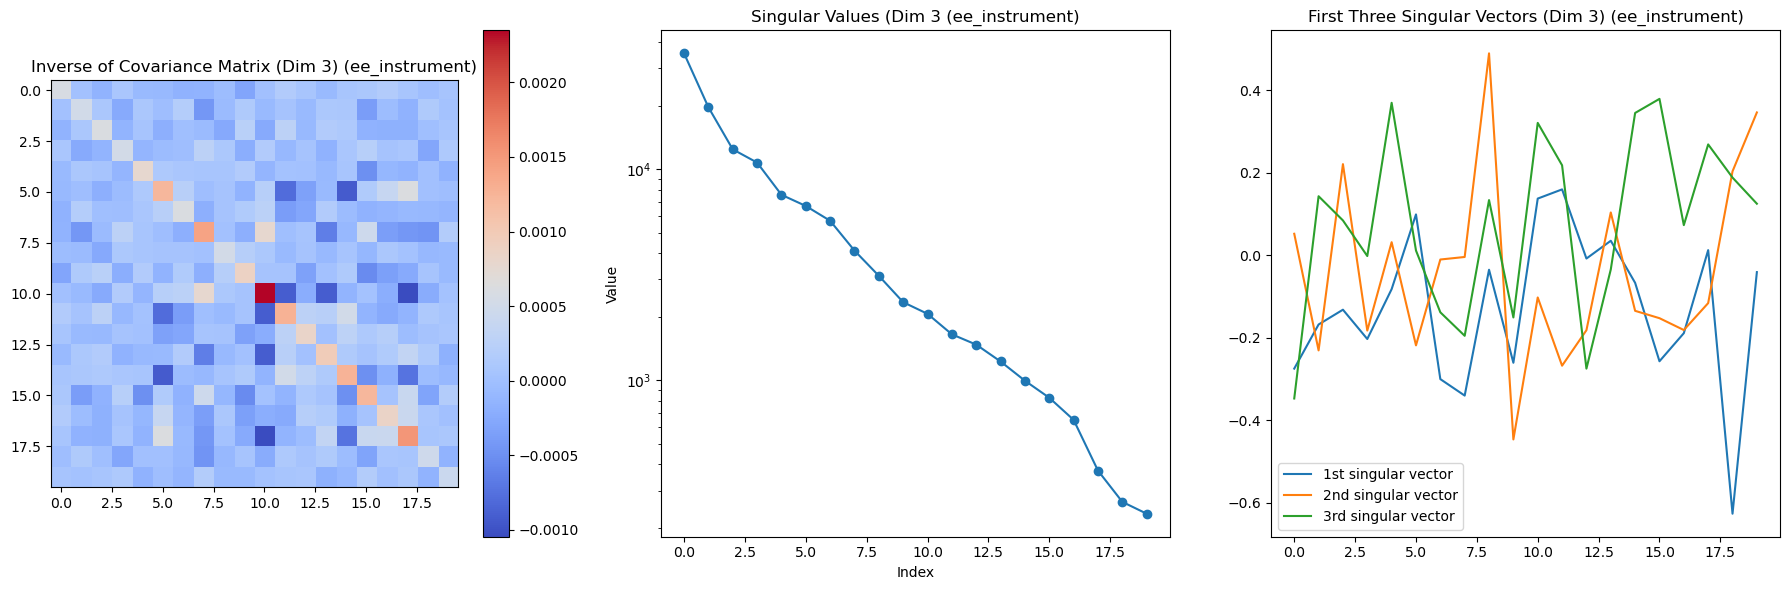

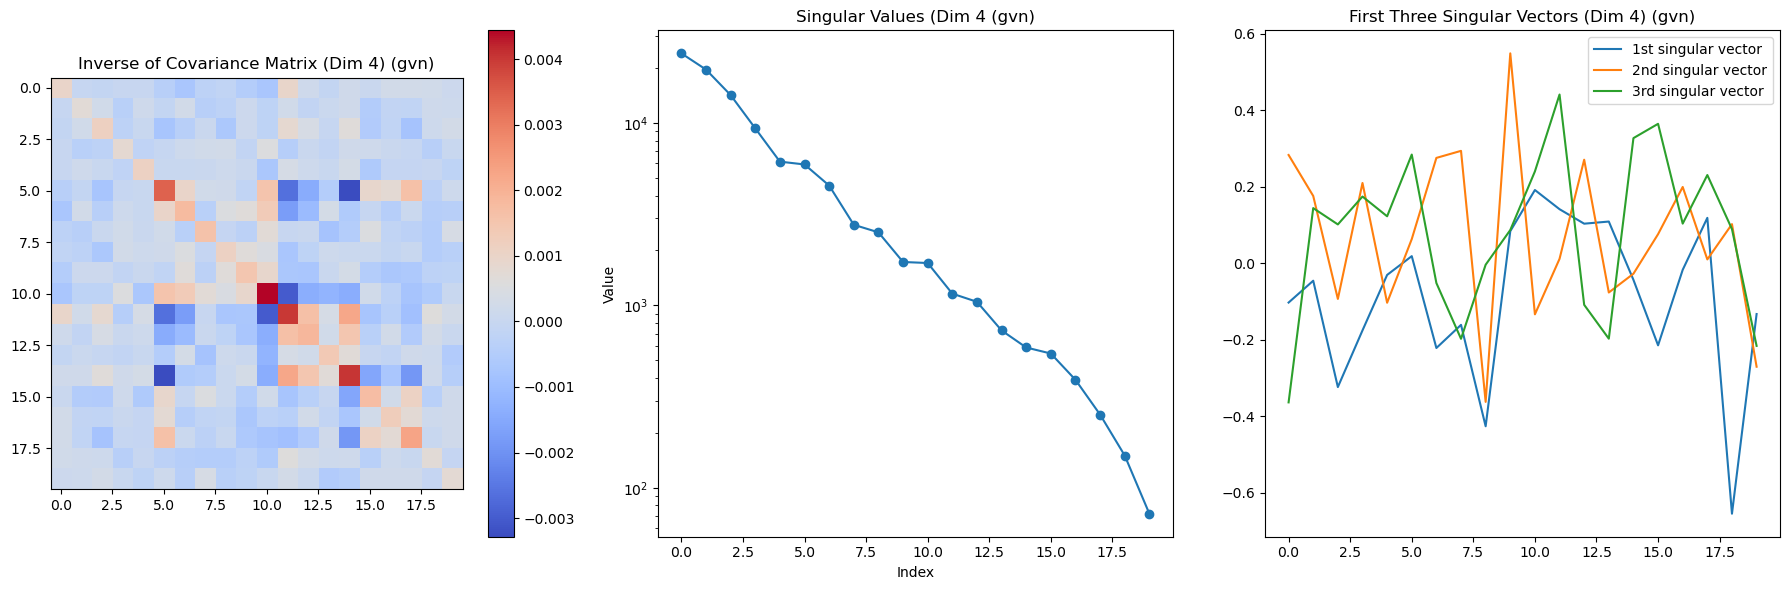

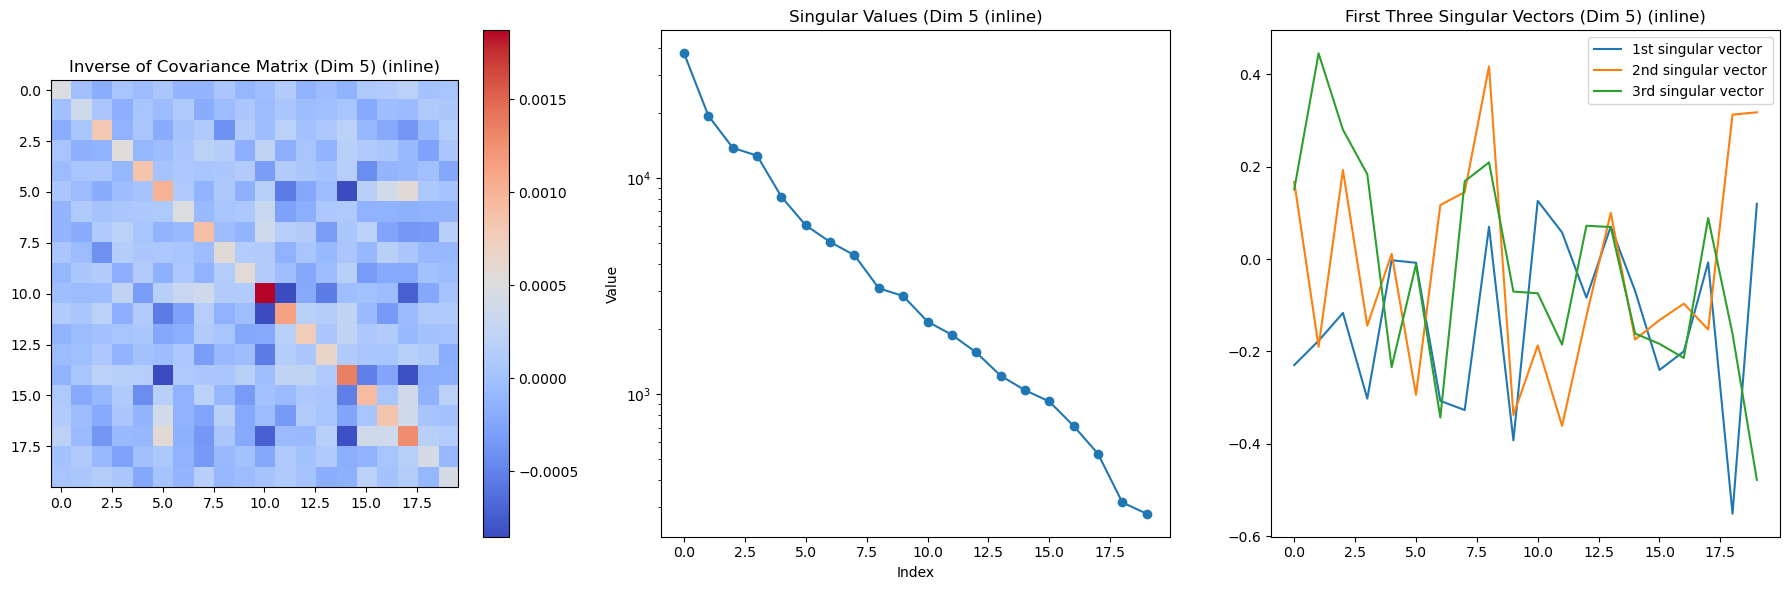

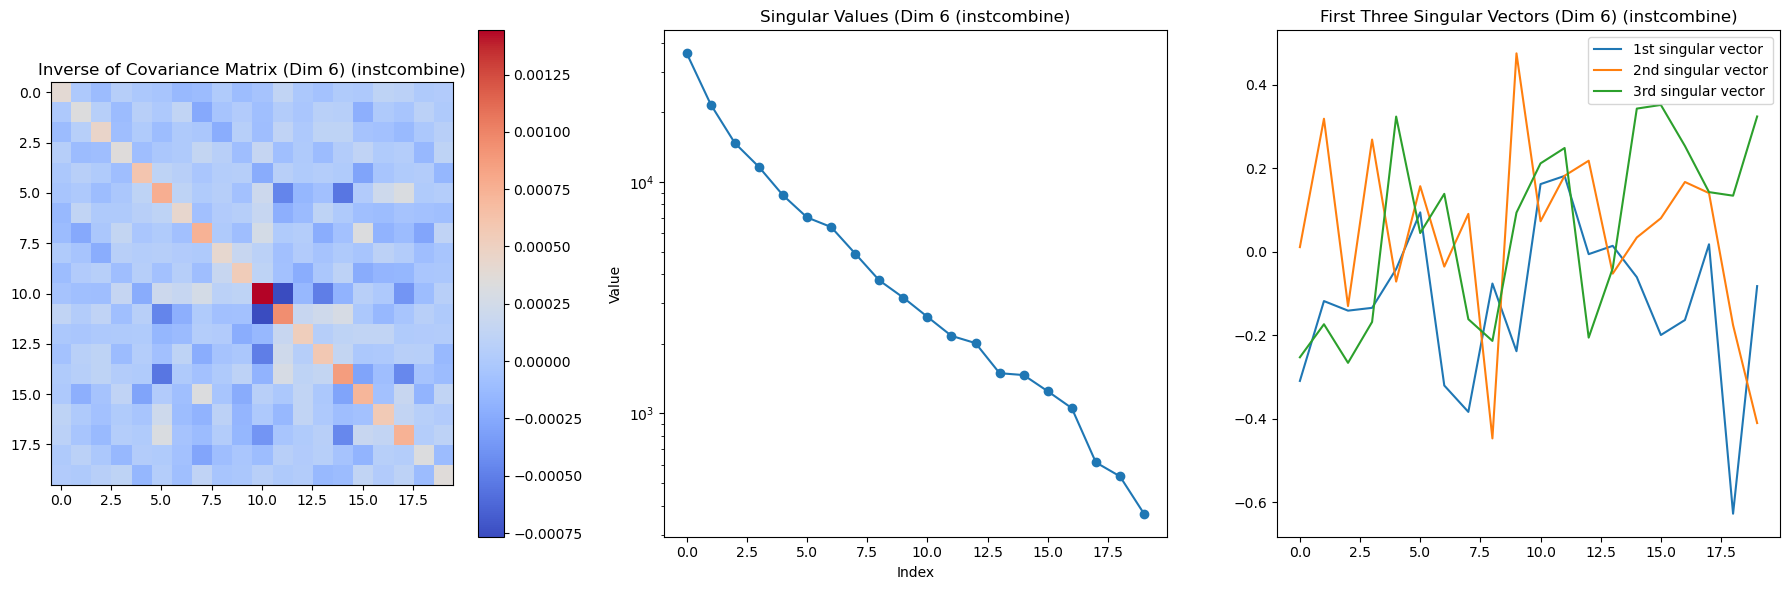

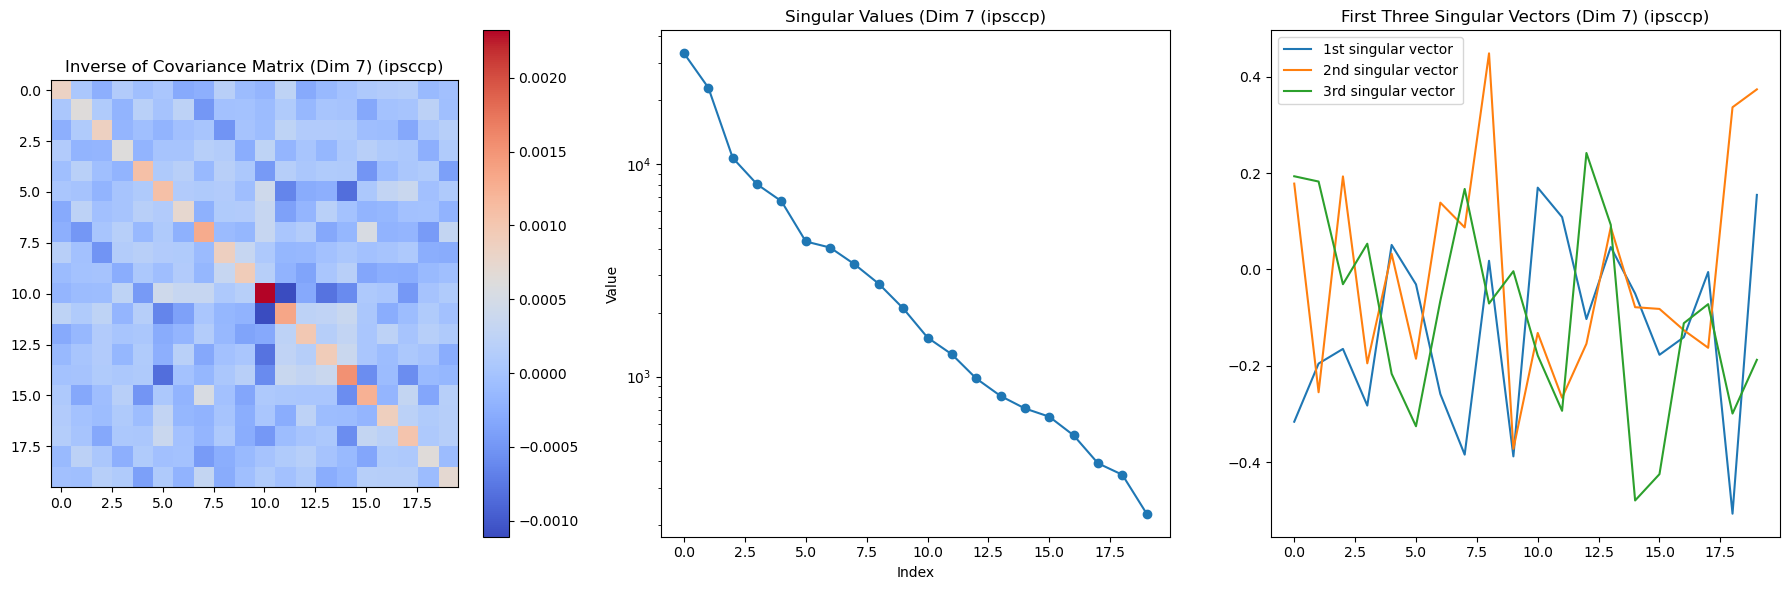

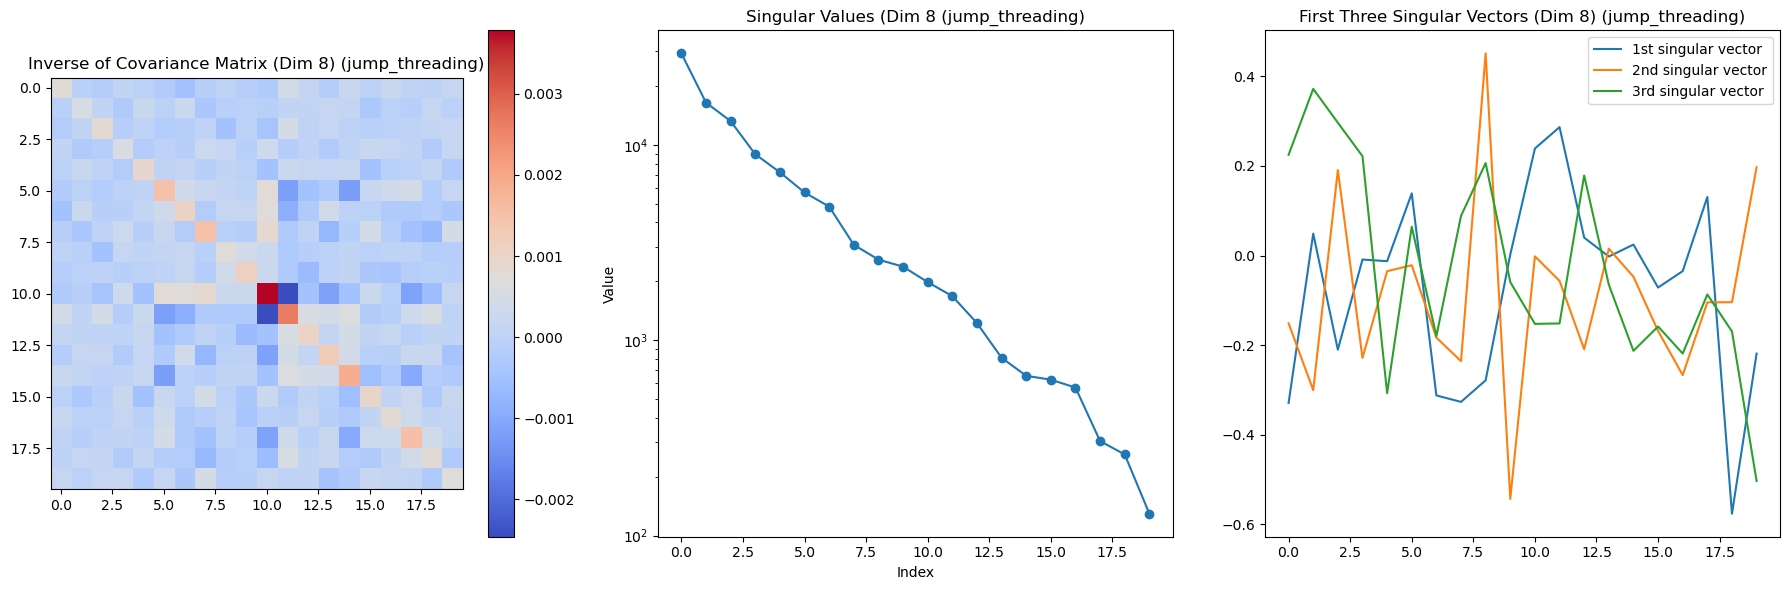

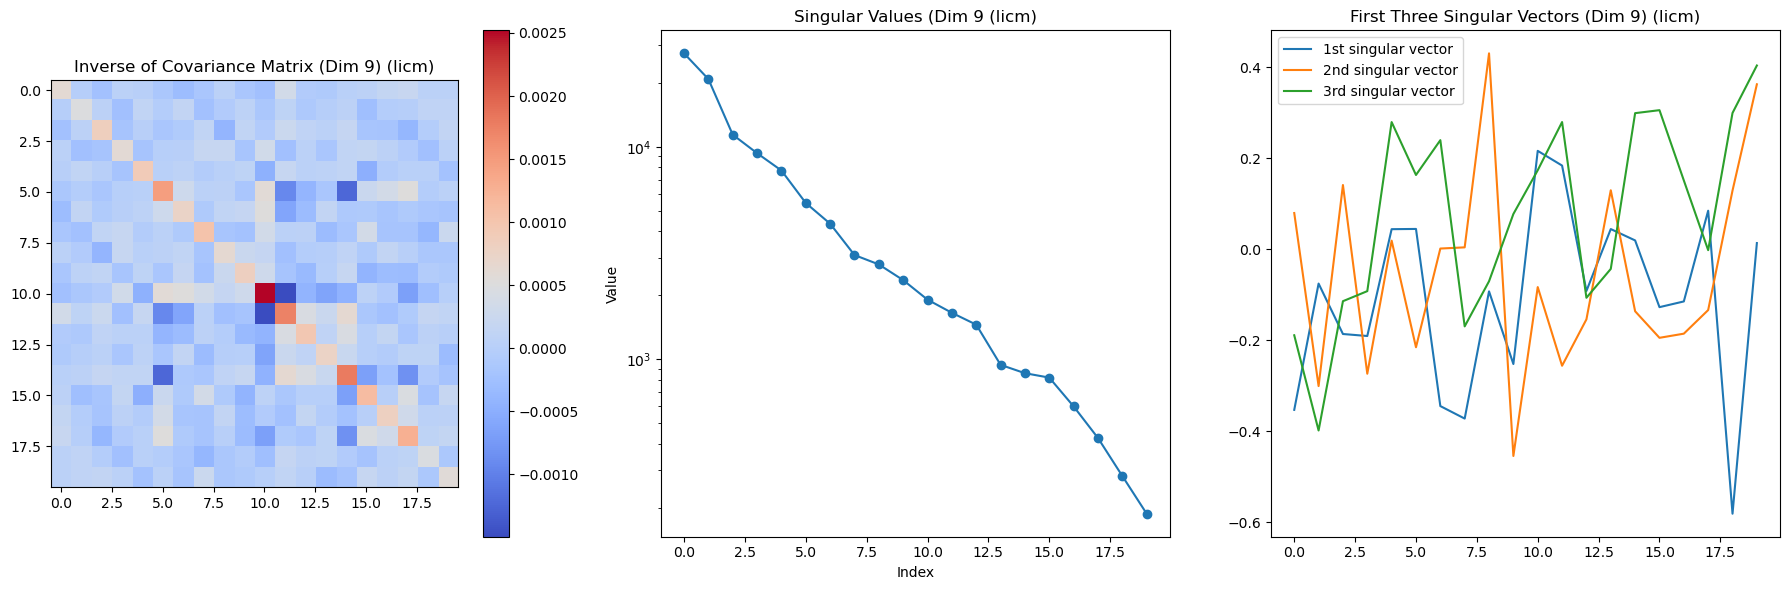

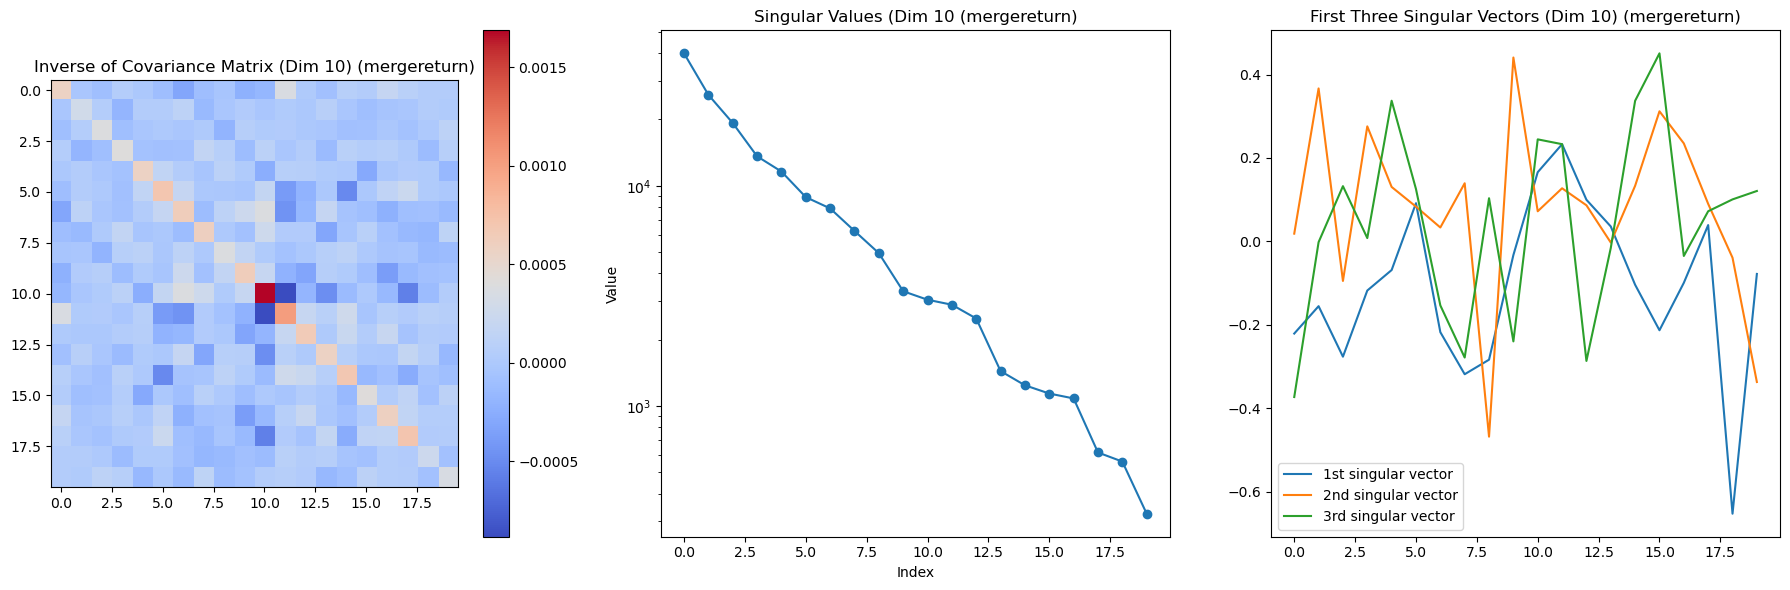

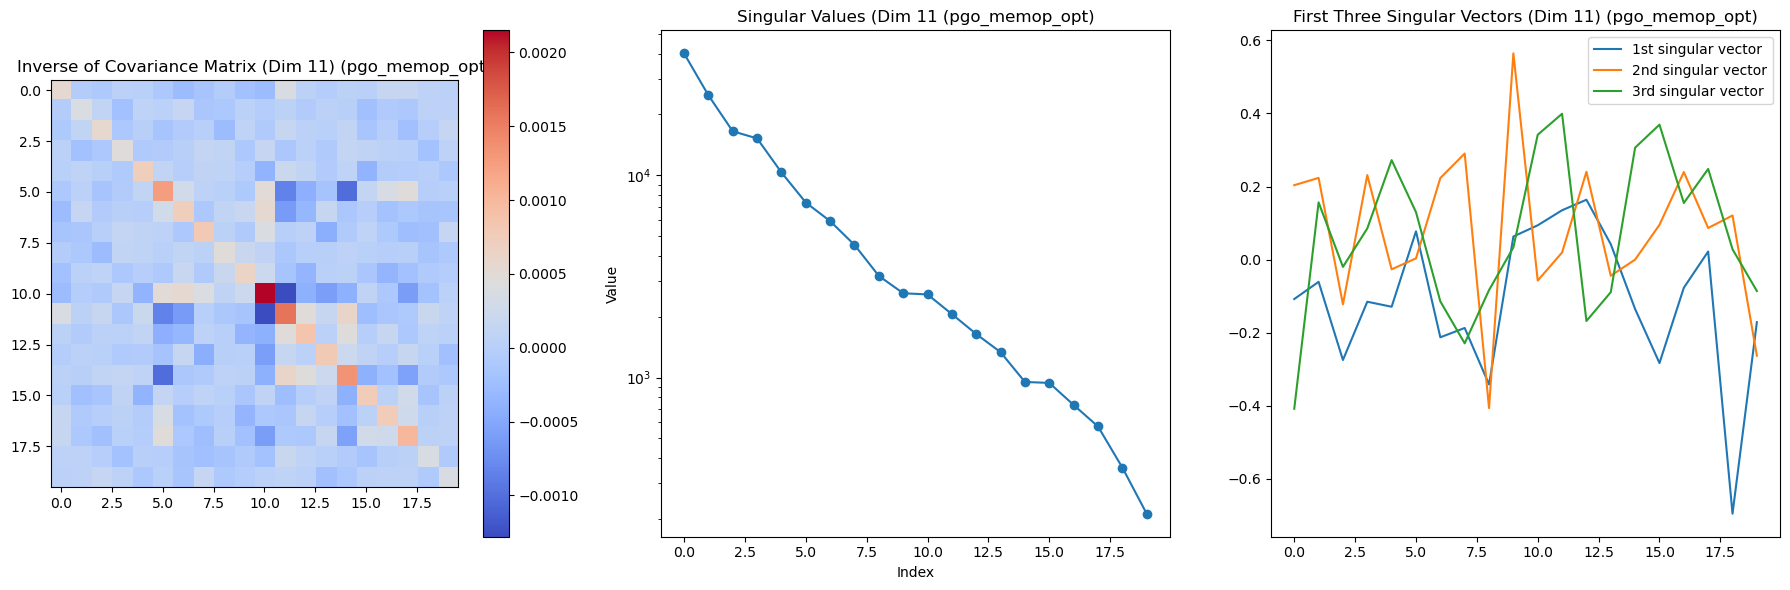

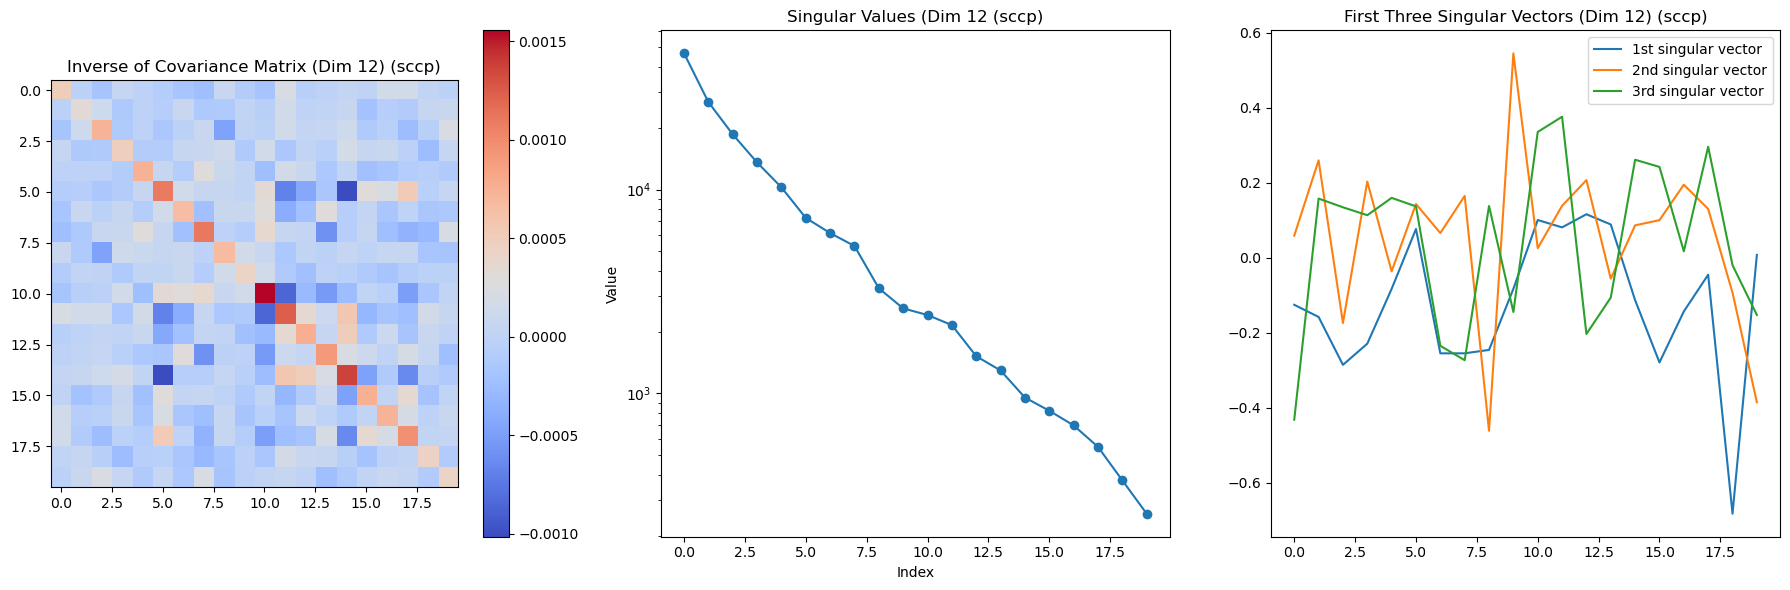

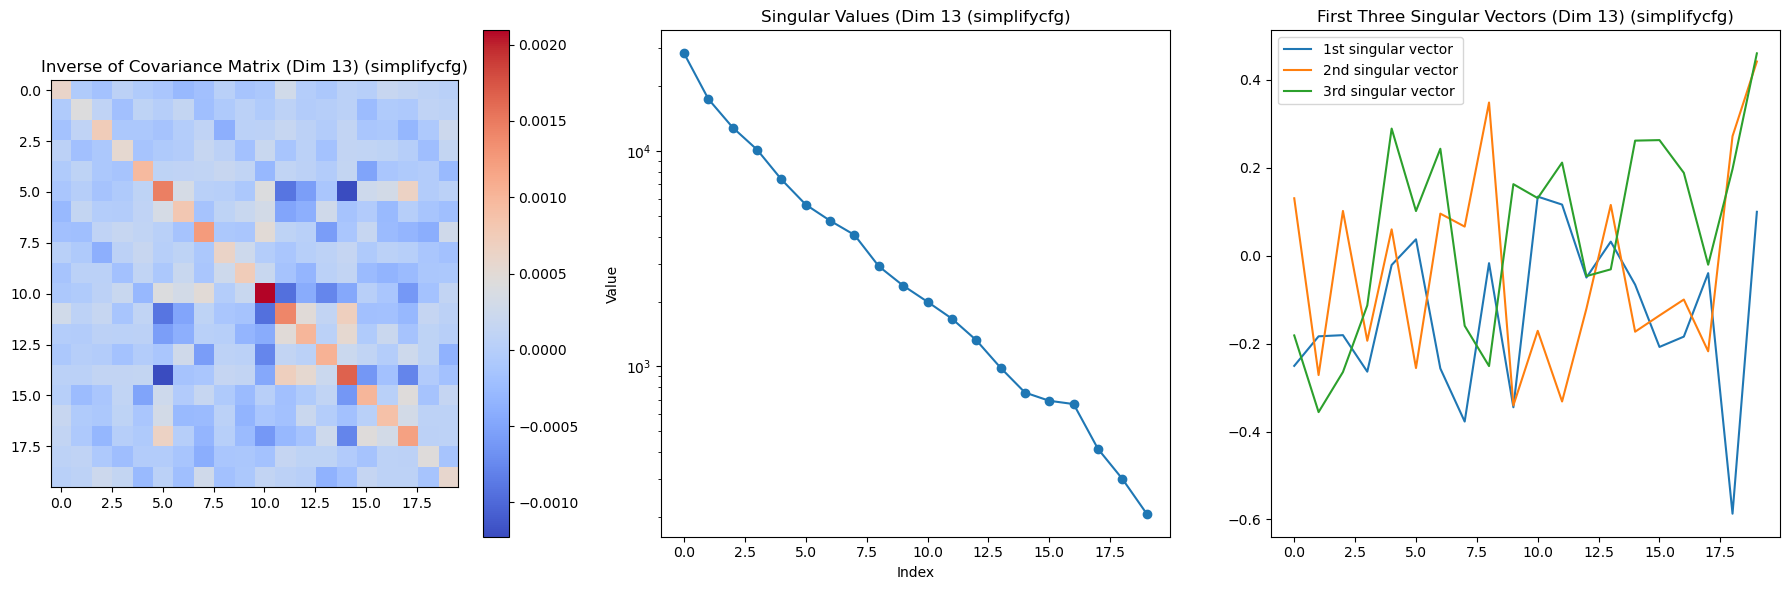

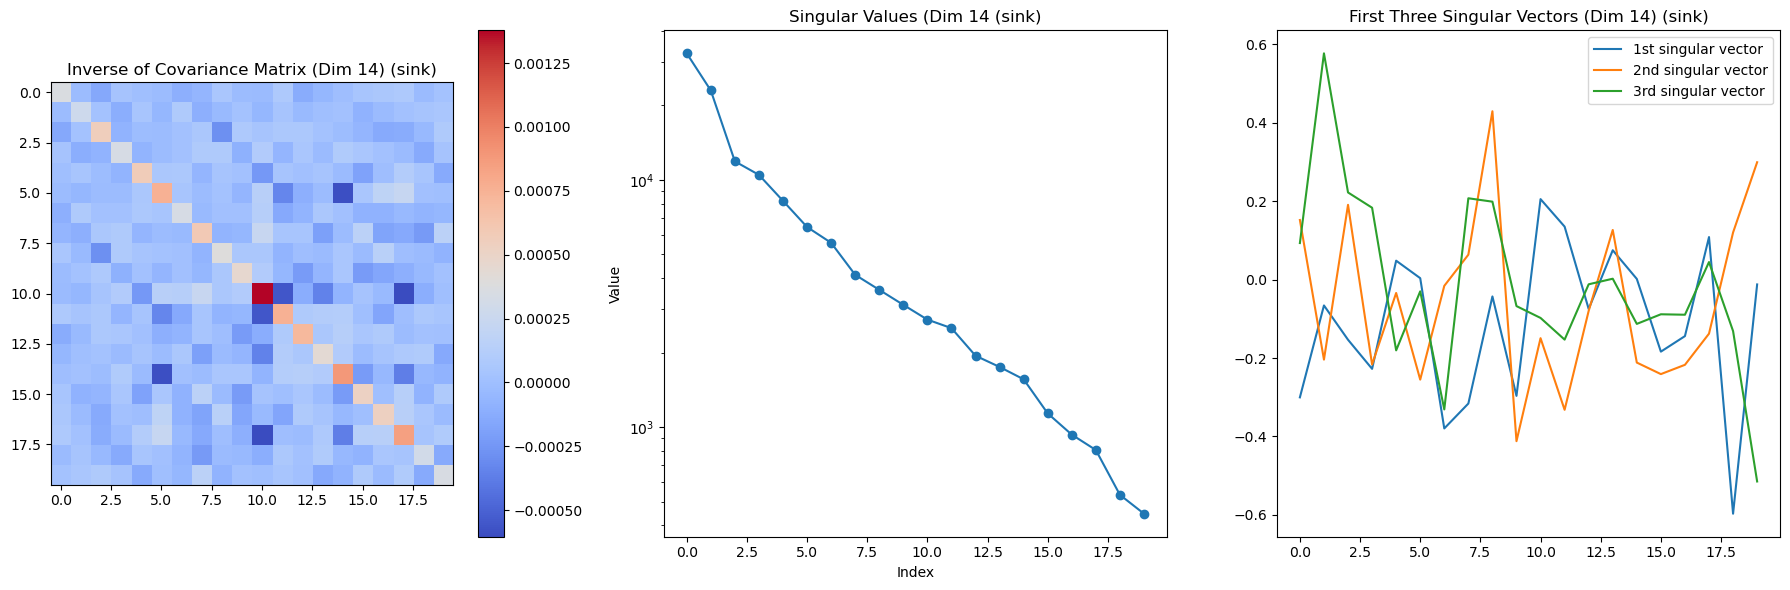

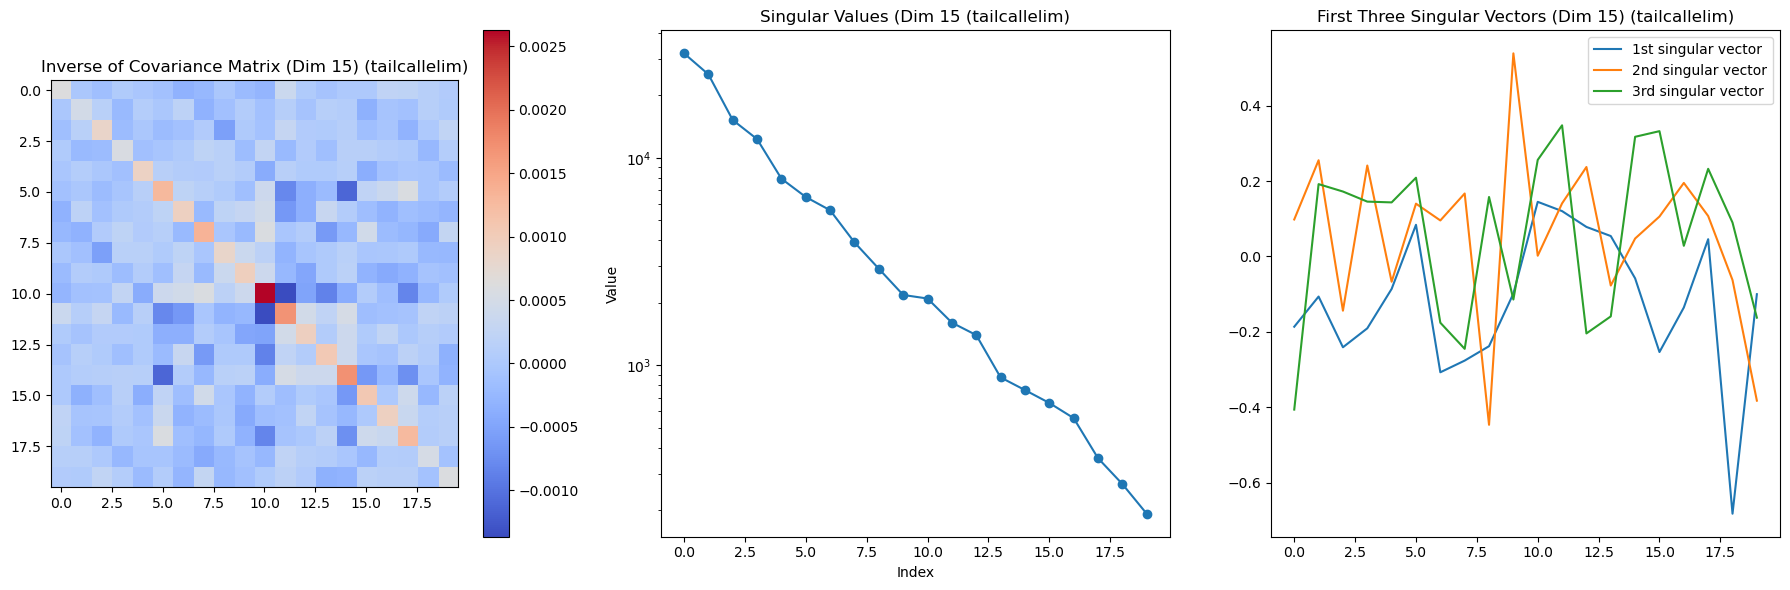

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# For each dimension, calculate and plot the inverse covariance matrix and the SVD components
for dim in range(num_dims):
    covariance_matrix = dimensional_model[dim]["covariance"].numpy()
    
    # Inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(covariance_matrix)
    
    # Compute the SVD
    U, S, Vt = np.linalg.svd(covariance_matrix)

    # Prepare the figure
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot the inverse covariance matrix
    im_inv = axs[0].imshow(inv_cov_matrix, cmap='coolwarm', interpolation='nearest')
    fig.colorbar(im_inv, ax=axs[0])
    axs[0].set_title(f'Inverse of Covariance Matrix (Dim {dim}) ({feature_names[dim]})')
    
    # Plot the singular values
    axs[1].semilogy(S, 'o-')
    axs[1].set_title(f'Singular Values (Dim {dim} ({feature_names[dim]})')
    axs[1].set_xlabel('Index')
    axs[1].set_ylabel('Value')
    
    # Plot the first two singular vectors (U matrix)
    axs[2].plot(U[:, 0], label='1st singular vector')
    axs[2].plot(U[:, 1], label='2nd singular vector')
    axs[2].plot(U[:, 2], label='3rd singular vector')
    axs[2].set_title(f'First Three Singular Vectors (Dim {dim}) ({feature_names[dim]})')
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()


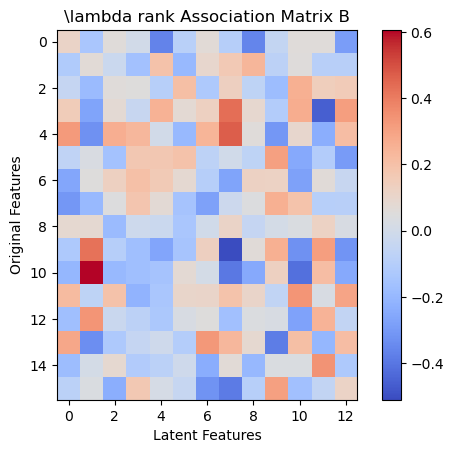

In [11]:
plt.imshow(B.numpy(), cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.title('\lambda rank Association Matrix B')
plt.xlabel('Latent Features')
plt.ylabel('Original Features')
plt.show()

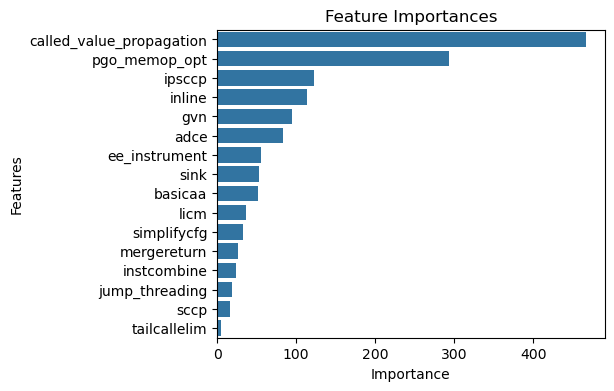

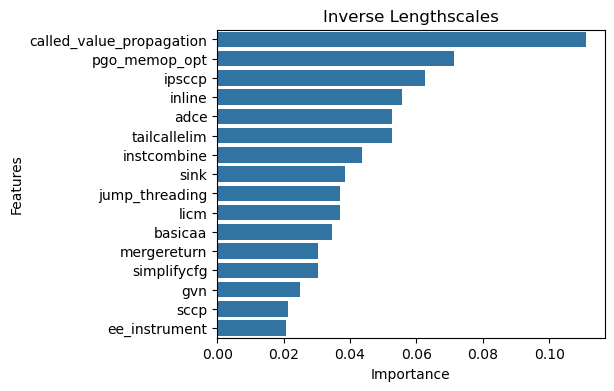

In [90]:
import plotly.graph_objects as go

# Example data: length scales for each feature
length_scales = model.median_lengthscale.detach()
features = feature_names

lengthscale_sorted = list(torch.sort(length_scales)[0])
lengthscale_argsorted = list(torch.argsort(length_scales))
feature_names = list(feature_names)
sorted_lengthscale = [1.0 / int(lengthscale_sorted[i].numpy()) for i in range(len(model.median_lengthscale))]
sorted_lengthscalefeatures = [feature_names[lengthscale_argsorted[i]] for i in range(len(model.median_lengthscale))]
fig = go.Figure(data=[
    go.Bar(x=sorted_features, y=sorted_lengthscale, marker_color='blue')
])

# Enhance interactivity
fig.update_layout(title_text='Interactive Visualization of Length Scales',
                  xaxis_title='Feature',
                  yaxis_title='Length Scale',
                  hovermode='closest')

#fig.show()

# Create a bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x=sorted_features.values, y=sorted_features.index)
plt.title('L1 linear Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()


# Create a bar plot
plt.figure(figsize=(5, 4))
sns.barplot(x=sorted_lengthscale, y=sorted_lengthscalefeatures)
plt.title('Inverse Lengthscales')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

Make a GRID search over groups of boolean masks 